In [1]:
import pandas as pd

In [2]:
# Load The Dataset

from google.colab import drive
drive.mount('/content/drive')

def load_data(file_path):
    df = pd.read_csv(file_path)
    print(f"Dataset shape: {df.shape}")
    return df

file_path = "/content/drive/MyDrive/Maccabi/ds_assignment_data.csv"
df = load_data(file_path)

Mounted at /content/drive
Dataset shape: (10000, 157)


## EDA - Exploratory Data Analysis - Hypertensive Disorders Prediction

In [3]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

# Setup styling
sns.set(style="whitegrid")
plt.rcParams["figure.figsize"] = (20, 10)

#### Step 1: Missingness Analysis

In [4]:
df.columns = df.columns.str.strip()

# Calculate missing percentage
missing_pct = df.isnull().mean() * 100
missing_pct_nonzero = missing_pct[missing_pct > 0].sort_values(ascending=False)
fully_missing_cols = missing_pct[missing_pct == 100].index.tolist()

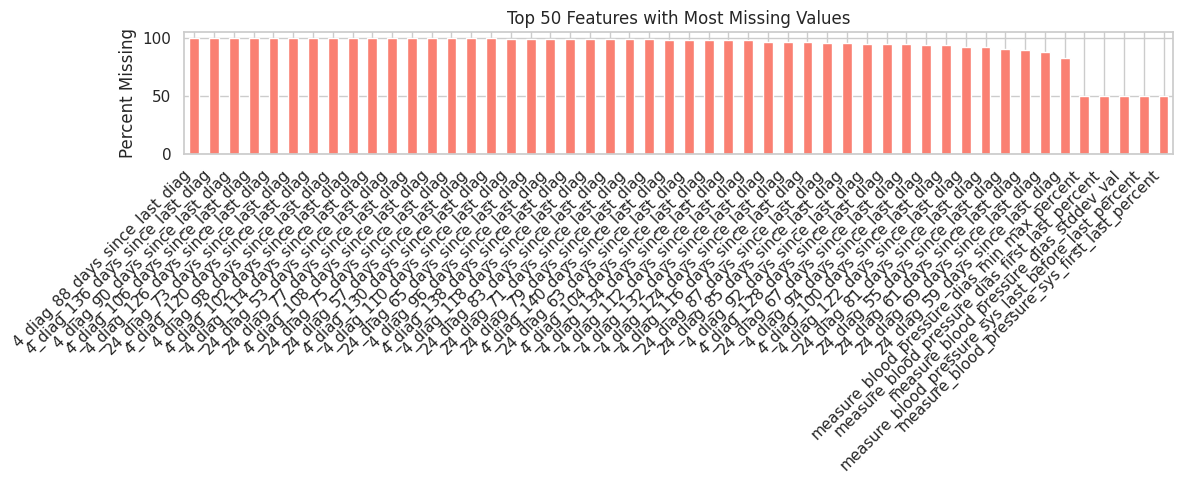

In [5]:
# Top 50 missing values plot
top_missing = missing_pct_nonzero.head(50)

plt.figure(figsize=(12, 5))
top_missing.plot(kind="bar", color='salmon')
plt.title("Top 50 Features with Most Missing Values")
plt.ylabel("Percent Missing")
plt.xticks(rotation=45, ha="right")
plt.tight_layout()
plt.show()

In [6]:
print("Columns with 100% missing (to drop):", fully_missing_cols)

Columns with 100% missing (to drop): ['4_diag_88_days_since_last_diag']


#### Understanding Missing Values

Missing values indicate that **information is absent** for a given feature in a particular record. In healthcare data, this is very common due to:
- Selective testing (e.g., not all patients get the same lab work),
- Data entry inconsistencies or system limitations,
- Irrelevance of a variable to a specific patient's case (e.g., no diagnosis recorded because none exists).

Missing data can:
- Bias models, especially when the data is **not missing at random (NMAR)**.
- Cause certain models (like logistic regression or SVMs) to **crash or degrade** in performance unless imputed.
- Result in **information loss** if you drop entire columns or rows.


| Strategy | Description | Best When... |
|---------|-------------|--------------|
| **Drop rows/columns** | Remove observations or features with too much missingness | Missing rate is very high and signal is weak |
| **Mean/median/mode imputation** | Replace missing values with statistical summaries | Data is missing at random (MAR) |
| **Indicator variable** | Add a binary column: "was this missing?" | Missingness itself may carry signal |
| **Model-based imputation** | Use KNN, regression, or deep models to predict missing values | When you want better accuracy and can afford complexity |
| **Do nothing** | Leave as-is (e.g., for tree-based models like XGBoost or CatBoost) | Model supports it and missingness is informative |



- Many features like `4_diag_88_days_since_last_diag` are **99–100% missing**. These likely represent diagnosis "day offsets" that weren't recorded for most patients.
- These are **sparse by design**, and we can consider:
  - Dropping columns that are **100% missing**.
  - Creating **binary indicators** for whether any diagnosis was recorded in that group.
  - **Aggregating** or **binning** day-offset columns (e.g., "any diag in last 90 days").

We'll handle missingness **strategically by feature group** later on, during feature engineering.

#### Step 2: Target Variable (Y) Distribution

/tmp/ipython-input-7-2033508621.py:10: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.countplot(x='Y', data=df, palette='Set2')


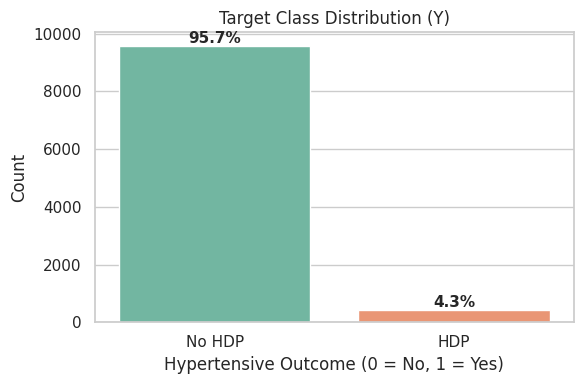

In [7]:
import matplotlib.pyplot as plt
import seaborn as sns

# Count values and percentages
target_counts = df['Y'].value_counts()
target_percents = df['Y'].value_counts(normalize=True) * 100

# Create the plot
plt.figure(figsize=(6, 4))
ax = sns.countplot(x='Y', data=df, palette='Set2')
plt.title("Target Class Distribution (Y)")
plt.xlabel("Hypertensive Outcome (0 = No, 1 = Yes)")
plt.ylabel("Count")
plt.xticks([0, 1], ['No HDP', 'HDP'])

# Annotate bars with percentages
for p in ax.patches:
    height = p.get_height()
    label_x = p.get_x() + p.get_width() / 2
    label_y = height
    percent = target_percents[int(p.get_x() + p.get_width()/2)]
    ax.annotate(f"{percent:.1f}%",
                (label_x, label_y),
                ha='center', va='bottom', fontsize=11, fontweight='bold')

plt.tight_layout()
plt.show()

##### Target Class Distribution: Hypertensive Disorders  

This chart shows the distribution of the binary target variable `Y`:  
- **Y = 0** → No hypertensive disorder during pregnancy (~95.7% of cases)
- **Y = 1** → One or more hypertensive disorders occurred (~4.3% of cases)  


This is a **highly imbalanced classification problem**, which is very common in healthcare. The vast majority of patients do not develop complications, but the **small minority who do** are exactly the ones we must identify.
  

Standard machine learning models trained on this data will tend to:
- **Predict 'No HDP' for everyone**, achieving high accuracy but missing nearly all at-risk cases.
- Be **biased toward the majority class**, especially if the model optimizes accuracy instead of recall or precision.


To address this:
- We'll use **class-weighted models** or **sampling techniques** (e.g., stratified k-fold).
- We'll evaluate models with **precision-recall curves** and **referral coverage under budget constraints**.
- Our ultimate goal is not classification but **ranking**: we want to refer the **most at-risk patients** for extra testing under a limited budget.

This sets the stage for a **screening-prioritization** approach that mimics real-world clinical decision-making.

#### Step 3: Diagnosis Source Breakdown

In [8]:
# Expected source flags from assignment
expected_sources = [
    'match_diag_after', 'match_measure_after',
    'match_rasham_after', 'match_aspirin_after', 'match_pdf_after'
]
actual_sources = [col for col in expected_sources if col in df.columns]

In [9]:
# Diagnostic subtype columns (used as proxy for match_diag_after)
diag_subtype_cols = [
    'secondary_hypertension_sum', 'essential_hypertension_sum',
    'hypertensive_heart_disease_sum', 'hypertensive_chronic_kidney_disease_sum',
    'hypertensive_heart_and_chronic_kidney_disease_sum',
    'pregnancy_hypertension_sum', 'preeclampsia_sum',
    'eclampsia_sum', 'labs_sum'
]

In [10]:
# Create proxy for match_diag_after
df['match_diag_after_proxy'] = df[diag_subtype_cols].fillna(0).sum(axis=1).gt(0).astype(int)

In [11]:
# Combine available sources
source_columns_full = ['match_diag_after_proxy'] + actual_sources
source_sums_full = df[df['Y'] == 1][source_columns_full].sum().sort_values(ascending=False)

/tmp/ipython-input-12-883409362.py:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.barplot(x=source_sums_full.values, y=source_sums_full.index, palette='Spectral')


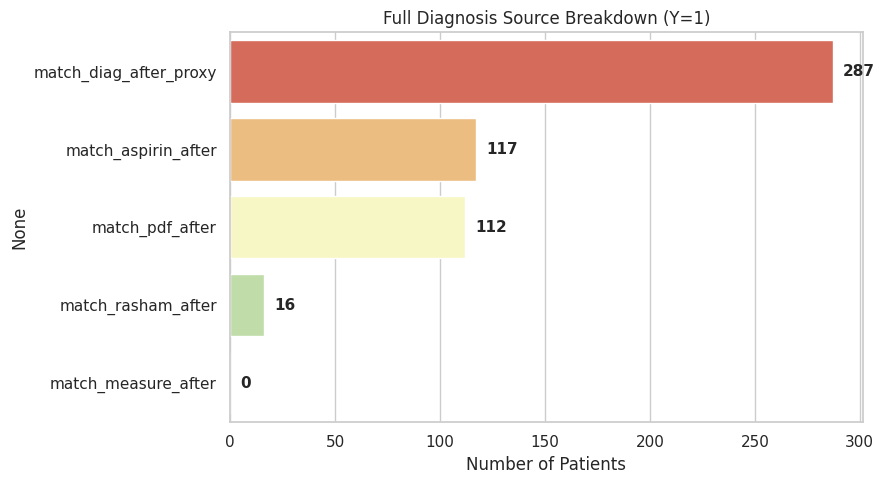

In [12]:
# Barplot: Source of Diagnosis Among Positive Cases (Y=1)
plt.figure(figsize=(9, 5))
ax = sns.barplot(x=source_sums_full.values, y=source_sums_full.index, palette='Spectral')
plt.title("Full Diagnosis Source Breakdown (Y=1)")
plt.xlabel("Number of Patients")

# Add numeric labels to the right of each bar
for p in ax.patches:
    value = int(p.get_width())
    y_position = p.get_y() + p.get_height() / 2
    ax.annotate(f"{value}",
                xy=(p.get_width() + 5, y_position),  # Slightly offset to the right
                va='center', ha='left',
                fontsize=11, fontweight='bold')

plt.tight_layout()
plt.show()

This chart visualizes how hypertensive diagnoses were detected among patients who developed a hypertensive disorder (i.e., `Y = 1`).

We include **all five diagnosis sources**:
- **match_diag_after_proxy**: Reconstructed from diagnostic subtype columns (e.g., preeclampsia, gestational hypertension)
- **match_aspirin_after**: Prescription of low-dose aspirin, often used as a preventative treatment
- **match_pdf_after**: Hospital admission or discharge notes
- **match_rasham_after**: Maccabi’s internal registry
- **match_measure_after**: Abnormal blood pressure measurements

---

#### Key Observations:
- The **diagnostic subtype flags** (our proxy for `match_diag_after`) are by far the most common indicator, highlighting their importance.
- Only a small number of diagnoses come directly from blood pressure measurements (`match_measure_after = 0`), which may reflect data logging issues or clinical practice patterns.
- All values are annotated to the **right of each bar** for quick comparison.

This breakdown is crucial for understanding which data sources most reliably capture at-risk patients — and which might require enhancement or integration in real-world deployment.

#### Step 4: Features By Group - Analysis

In [13]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

def plot_features_by_target(
    df, feature_cols, target_col="Y", max_cols=3, bins=30,
    title_prefix="Feature", log_scale=False, binarize=False, return_summary=True
):
    """
    Plot histograms of numeric features split by binary target, with optional log or binarization.

    Parameters:
        df (pd.DataFrame): Source dataframe
        feature_cols (list): Feature column names to plot
        target_col (str): Binary target column
        max_cols (int): Number of plots per row
        bins (int): Number of histogram bins
        title_prefix (str): Title prefix for plots
        log_scale (bool): If True, apply log1p transform to feature values
        binarize (bool): If True, convert feature to binary (e.g., > 0 = 1)
        return_summary (bool): If True, return a DataFrame of summary stats

    Returns:
        pd.DataFrame (optional): Summary statistics of the features
    """

    plot_df = df[feature_cols + [target_col]].copy()
    for col in feature_cols:
        plot_df[col] = pd.to_numeric(plot_df[col], errors='coerce')
    plot_df[target_col] = pd.to_numeric(plot_df[target_col], errors='coerce')
    plot_df = plot_df.dropna()
    plot_df = plot_df[plot_df[target_col].isin([0, 1])]

    if log_scale:
        for col in feature_cols:
            plot_df[col] = np.log1p(plot_df[col])

    if binarize:
        for col in feature_cols:
            plot_df[col] = (plot_df[col] > 0).astype(int)

    # Plotting
    n_feats = len(feature_cols)
    ncols = min(max_cols, n_feats)
    nrows = -(-n_feats // ncols)

    fig, axes = plt.subplots(nrows=nrows, ncols=ncols, figsize=(6 * ncols, 4 * nrows))
    axes = axes.flatten() if n_feats > 1 else [axes]

    for i, col in enumerate(feature_cols):
        sns.histplot(
            data=plot_df, x=col, hue=target_col, element="step", stat="density",
            common_norm=False, ax=axes[i], palette="Set2", bins=bins, alpha=0.6
        )
        axes[i].set_title(col.replace("lab_", "").replace("_last_value", ""), fontsize=11)
        axes[i].set_xlabel("")
        axes[i].set_ylabel("Density")

    for j in range(len(feature_cols), len(axes)):
        fig.delaxes(axes[j])

    plt.suptitle(f"{title_prefix} Distributions by Outcome ({target_col})", fontsize=14)
    plt.tight_layout(rect=[0, 0.03, 1, 0.95])
    plt.show()

    if return_summary:
        return plot_df[feature_cols].describe().T.round(2)


In [14]:
cbc_features = [
    'lab_White Blood Cells (WBC)_last_value',
    'lab_Red Blood Cells (RBC)_last_value',
    'lab_Hemoglobin (HGB)_last_value',
    'lab_Hematocrit (HCT)_last_value',
    'lab_Mean Corpuscular Hemoglobin (MCH)_last_value',
    'lab_Mean Corpuscular Volume (MCV)_last_value',
    'lab_Mean Corpuscular Hemoglobin Concentration (MCHC)_last_value',
    'lab_Platelets (PLT)_last_value',
    'lab_Mean Platelet Volume (MPV)_last_value',
    'lab_Red Cell Distribution Width (RDW)_last_value',
    'lab_Neutrophils_1_last_value', 'lab_Lymphocytes_1_last_value',
    'lab_Monocytes_1_last_value', 'lab_Eosinophils_1_last_value', 'lab_Basophils_1_last_value',
    'lab_Neutrophils_2_last_value', 'lab_Lymphocytes_2_last_value',
    'lab_Monocytes_2_last_value', 'lab_Eosinophils_2_last_value', 'lab_Basophils_2_last_value'
]

biochem_features = [
    "lab_papp_a_MoM_last_value", "lab_papp_a_abs_last_value",
    "lab_b_hcg_MoM_last_value", "lab_b_hcg_abs_last_value",
    "lab_NT_MoM_last_value", "lab_NT_abs_last_value",
    "lab_weight_at_lab_time"
]

urine_features = ["lab_Protein-U_last_value", "lab_pH-U_last_value"]

bp_features = [
    "measure_blood_pressure_sys_mean_percent",
    "measure_blood_pressure_sys_max_percent",
    "measure_blood_pressure_sys_last_before_last_percent",
    "measure_blood_pressure_sys_stddev_val",
    "measure_blood_pressure_dias_mean_percent",
    "measure_blood_pressure_dias_max_percent",
    "measure_blood_pressure_dias_last_before_last_percent",
    "measure_blood_pressure_dias_stddev_val"
]

demo_features = ["demog_customer_age", "demog_capitationcoefficient", "demog_SES"]


##### CBC Labs Distribution Histograms


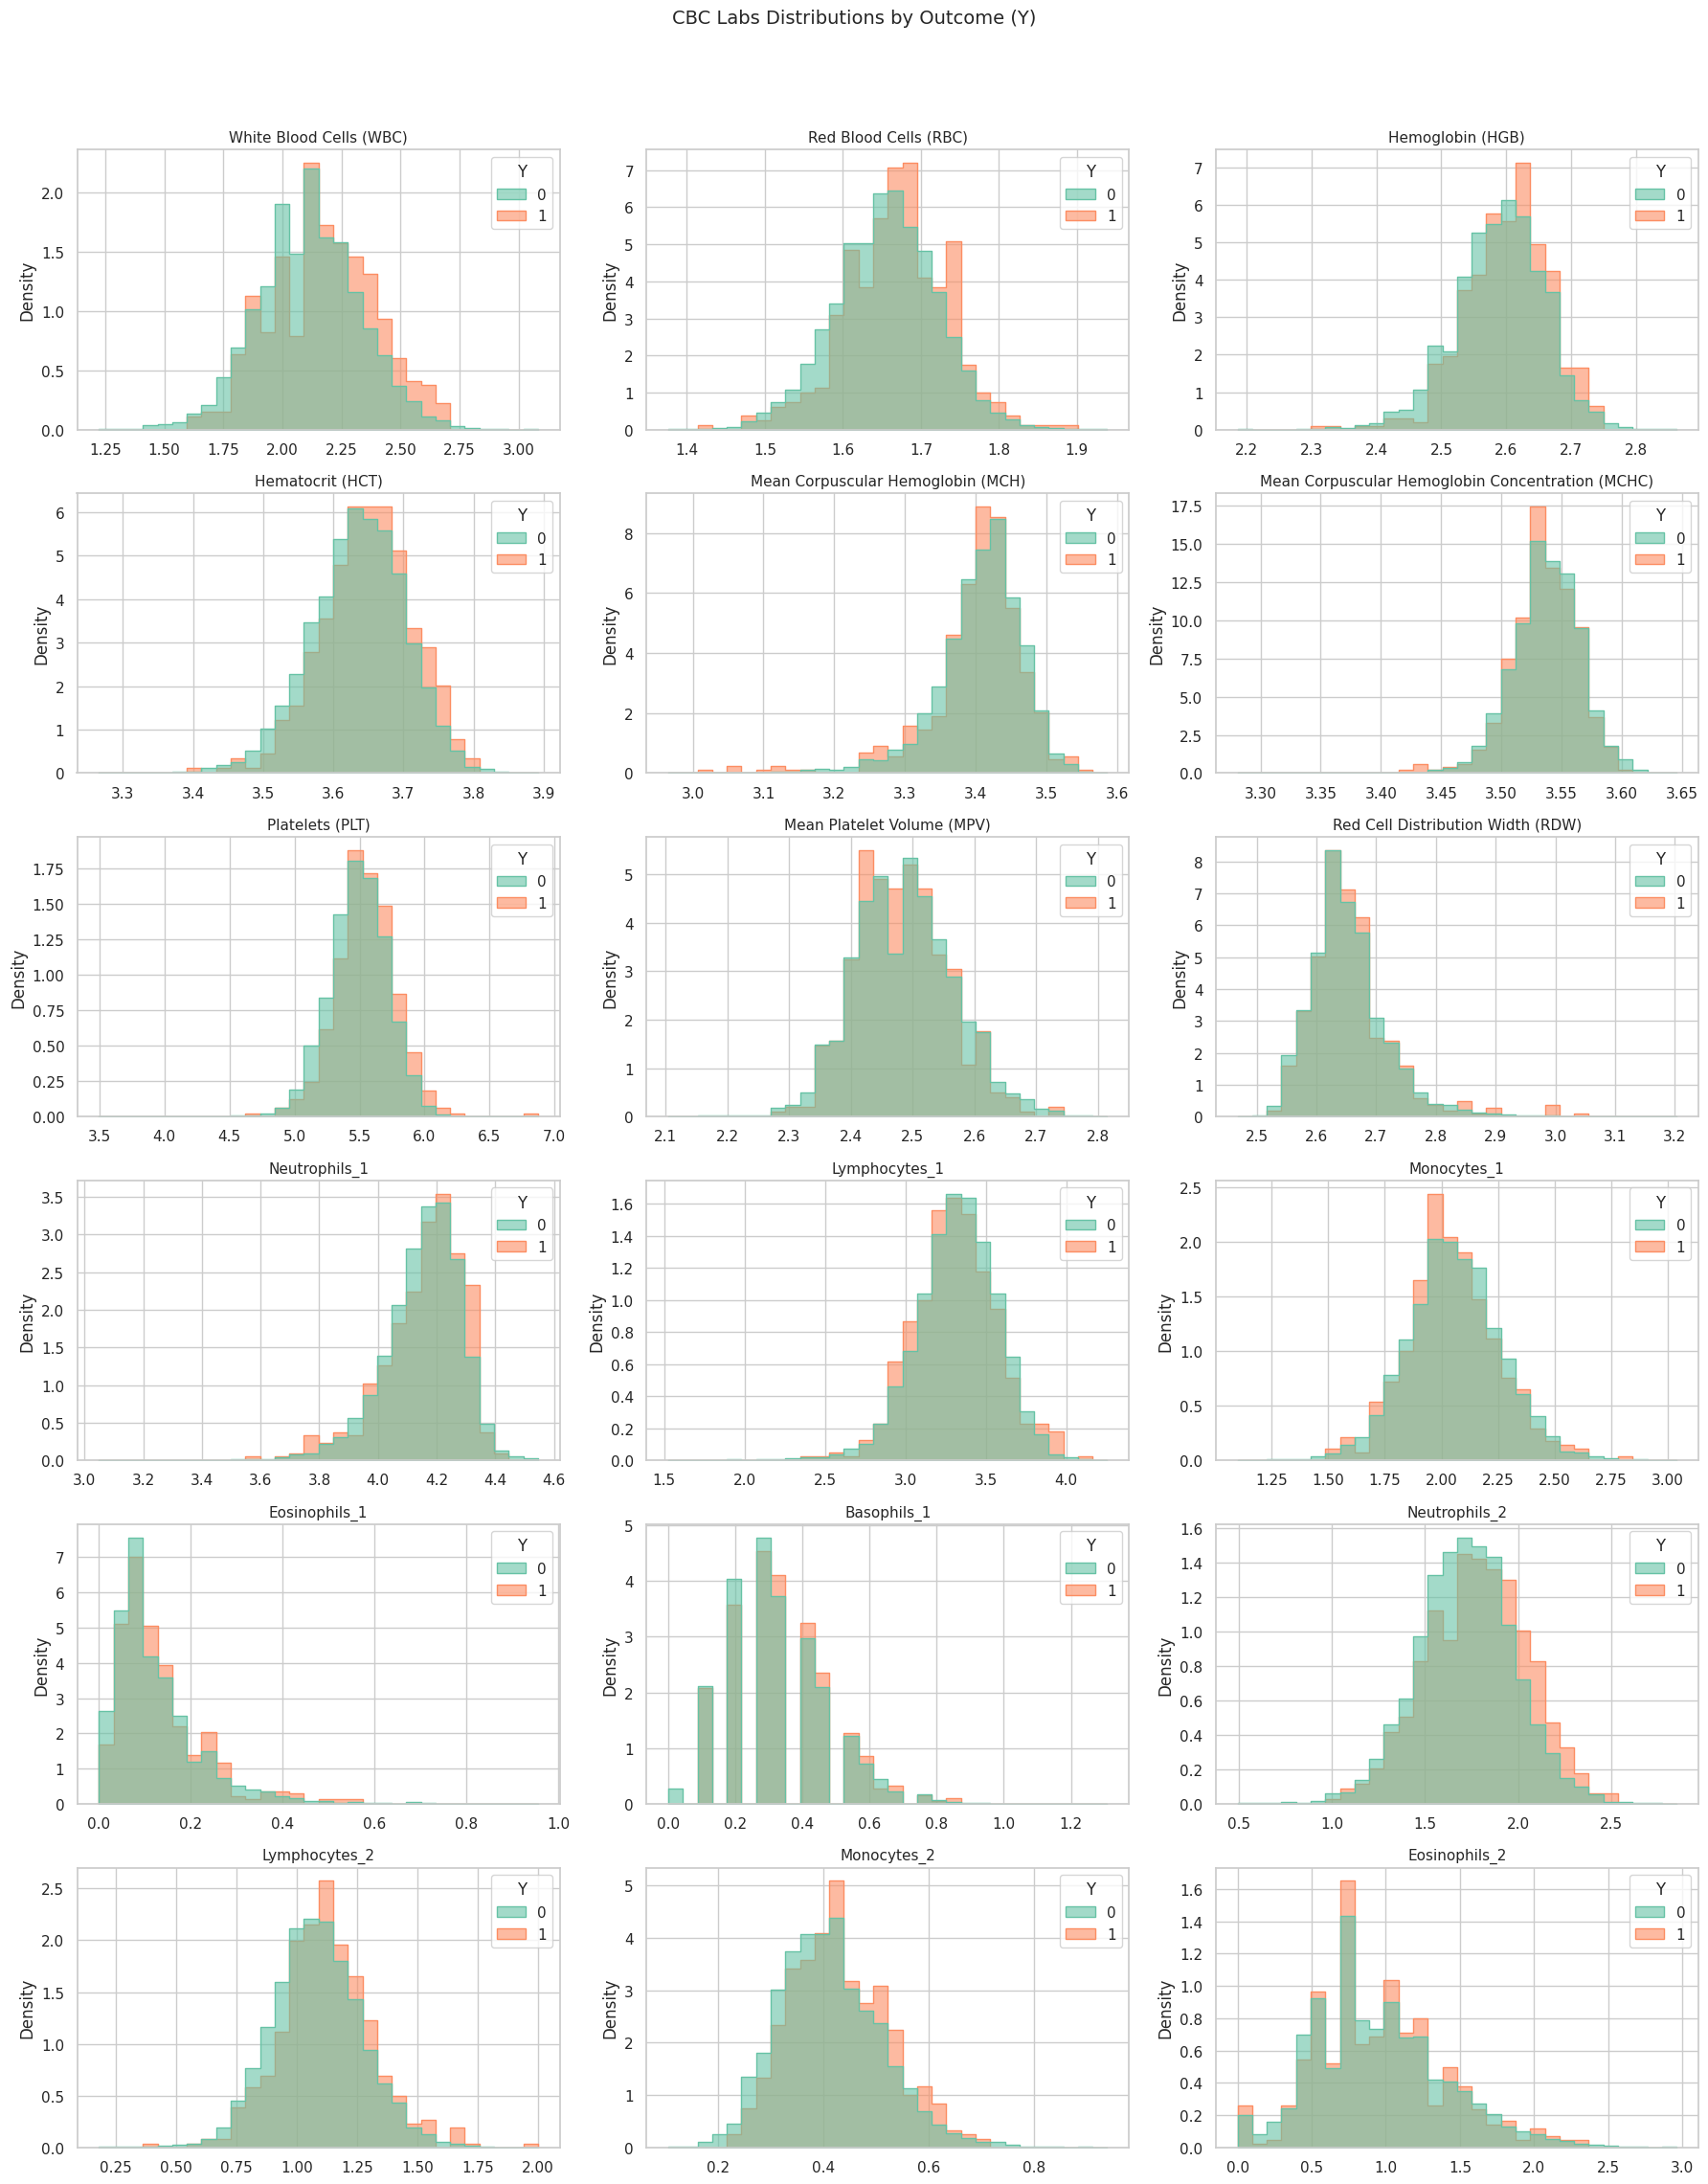

,count,mean,std,min,25%,50%,75%,max
lab_White Blood Cells (WBC)_last_value,9910.0,2.12,0.22,1.22,1.97,2.12,2.25,3.08
lab_Red Blood Cells (RBC)_last_value,9910.0,1.66,0.07,1.38,1.61,1.66,1.70,1.94
lab_Hemoglobin (HGB)_last_value,9910.0,2.59,0.07,2.19,2.55,2.60,2.63,2.86
lab_Hematocrit (HCT)_last_value,9910.0,3.64,0.07,3.27,3.59,3.64,3.68,3.89
lab_Mean Corpuscular Hemoglobin (MCH)_last_value,9910.0,3.41,0.06,2.97,3.38,3.41,3.44,3.59
lab_Mean Corpuscular Hemoglobin Concentration (MCHC)_last_value,9910.0,3.54,0.03,3.28,3.52,3.54,3.56,3.65
lab_Platelets (PLT)_last_value,9910.0,5.49,0.23,3.50,5.35,5.50,5.65,6.87
lab_Mean Platelet Volume (MPV)_last_value,9910.0,2.49,0.08,2.10,2.43,2.48,2.54,2.82
lab_Red Cell Distribution Width (RDW)_last_value,9910.0,2.65,0.07,2.47,2.61,2.65,2.69,3.20
lab_Neutrophils_1_last_value,9910.0,4.15,0.13,3.05,4.08,4.17,4.24,4.55


In [15]:
filtered_cbc_features = [col for col in cbc_features if col in df.columns]
plot_features_by_target(df, filtered_cbc_features, title_prefix="CBC Labs", log_scale=True)

##### CBC Lab Value Insights:
* **White Blood Cells (WBC)**: Slight rightward shift for `Y=1`, possibly reflecting inflammation.

* **Red Blood Cells (RBC) & Hemoglobin (HGB)**: Small elevation for `Y=1` could hint at compensation or hematologic risk.

* **Platelets (PLT)**: More right-tail skew in `Y=1`, though overlapping.

* **Hematocrit (HCT)**: Overlaps heavily, slight mean difference.

##### Biochemical Labs Distribution Histograms

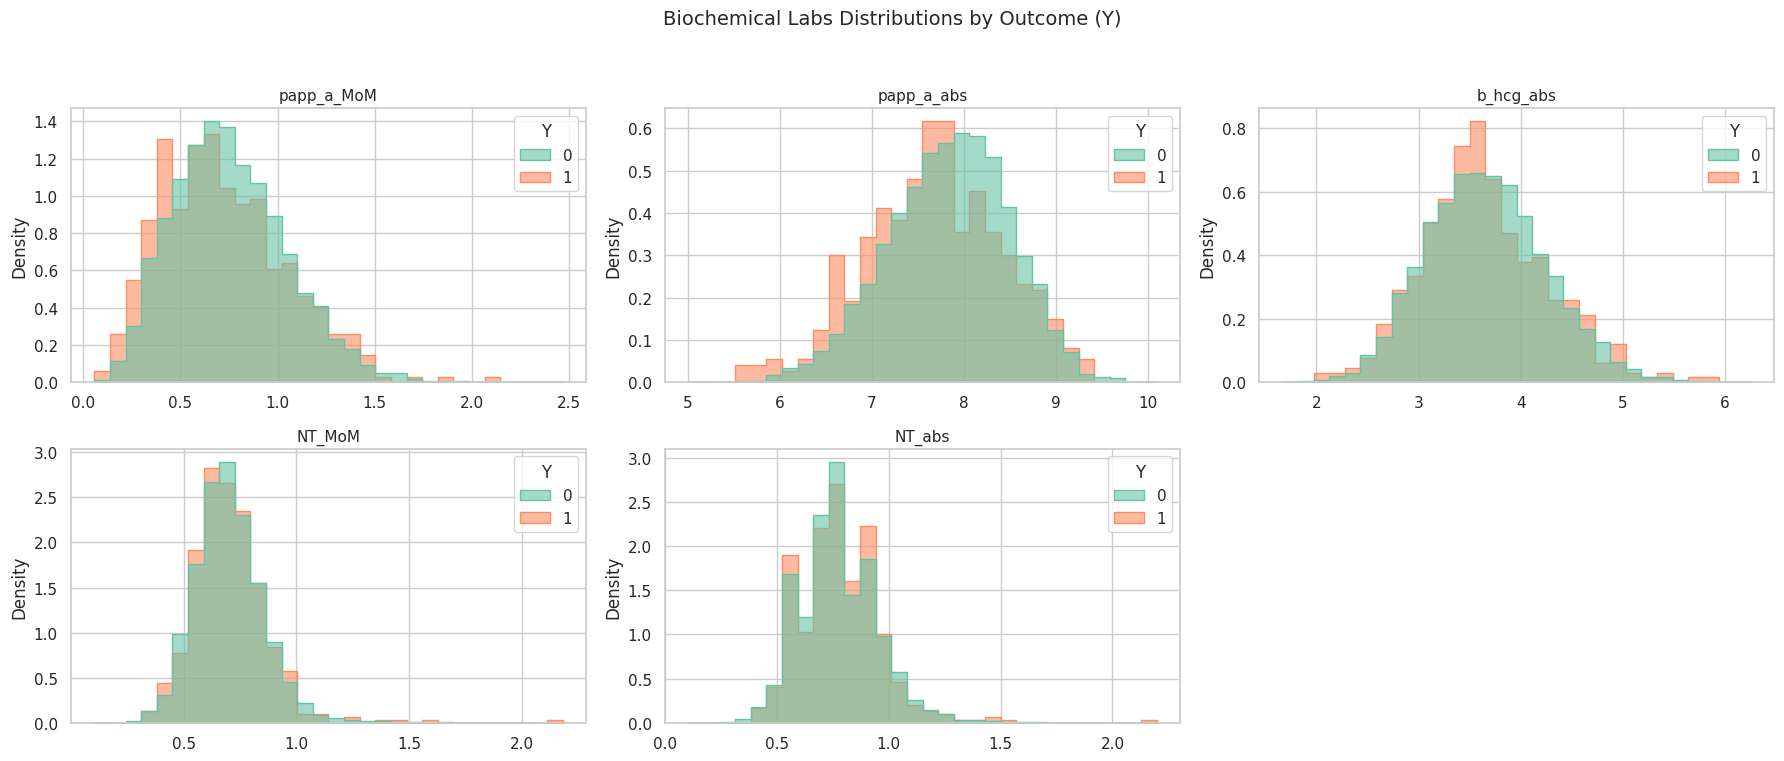

,count,mean,std,min,25%,50%,75%,max
lab_papp_a_MoM_last_value,9960.0,0.75,0.29,0.06,0.54,0.73,0.94,2.47
lab_papp_a_abs_last_value,9960.0,7.83,0.67,5.00,7.38,7.86,8.30,10.09
lab_b_hcg_abs_last_value,9960.0,3.66,0.59,1.67,3.25,3.64,4.04,6.25
lab_NT_MoM_last_value,9960.0,0.70,0.15,0.10,0.60,0.69,0.79,2.18
lab_NT_abs_last_value,9960.0,0.77,0.17,0.10,0.68,0.74,0.88,2.20


In [16]:
filtered_biochem_features = [col for col in biochem_features if col in df.columns]
plot_features_by_target(df, filtered_biochem_features, title_prefix="Biochemical Labs", log_scale=True)

##### Biochemical Lab Value Insights

**PAPP-A (MoM)**
* **Observation**: Values tend to be slightly lower in patients who later developed hypertensive disorders (`Y=1`), with a subtle left-shift.
* **Clinical Insight**: Lower levels of PAPP-A (Pregnancy-Associated Plasma Protein A) are associated with placental dysfunction and have been linked in literature to increased risk for preeclampsia and other complications.
* **Modeling Implication**: This feature may carry early predictive signal. Consider using as-is or binning for robustness.  

**PAPP-A (absolute)**
* **Observation**: Similar shape to the MoM version; long right tail with a lower central tendency for `Y=1`.
* **Clinical Insight**: Absolute values are harder to interpret directly but may reflect the same biological trend.
* **Modeling Tip**: MoM version is preferred for standardization, but absolute value may be used as a supporting feature.  

**β-hCG (absolute)**
* **Observation**: Overlapping distributions but a slightly higher density at lower values for Y=1.

* **Clinical Insight**: Low β-hCG may reflect abnormal trophoblastic activity or placental function, though findings are less consistent than PAPP-A.

* **Modeling Insight**: May offer complementary signal when combined with PAPP-A and NT.


**NT (Nuchal Translucency) MoM and Absolute**
* **Observation**: Distribution is mostly overlapping; very subtle increase in upper range for Y=1.

* **Clinical Insight**: NT is primarily used for aneuploidy screening, but elevated NT may indirectly signal placental or cardiovascular strain.

* **Modeling Tip**: Alone it’s weak, but may become valuable when used in interactions or nonlinear models.


##### Summary:


| Feature      | Signal Strength | Direction for `Y=1` | Interpretation         |
| ------------ | --------------- | ----------------- | ---------------------- |
| PAPP-A MoM   | Moderate      | Lower             | Placental risk marker  |
| PAPP-A abs   | Moderate      | Lower             | Confirms MoM trend     |
| β-hCG abs    | Weak-Med     | Slightly lower    | Placental support role |
| NT MoM / abs | Weak         | Slightly higher   | Not useful alone       |


#### Urine Labs

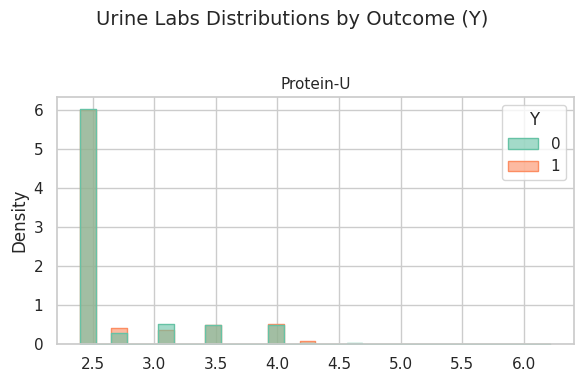

,count,mean,std,min,25%,50%,75%,max
lab_Protein-U_last_value,5757.0,2.63,0.48,2.4,2.4,2.4,2.4,6.22


In [17]:
urine_features
filtered_urine_features = [col for col in urine_features if col in df.columns]
plot_features_by_target(df, filtered_urine_features, title_prefix="Urine Labs", log_scale=True)

##### Urine Lab Value Insights
**Urine Protein (Protein-U)**

* **Observation**: Most patients have a baseline value (likely a default or minimum test value like 10.0). The distribution is sharply peaked at that value, but there's a long right tail, more prominent in `Y=1`.

* **Clinical Insight**: Proteinuria is a hallmark of preeclampsia. Even small elevations in early proteinuria may signal developing endothelial dysfunction.

* **Modeling Tip**: Raw values have limited distributional power due to clustering. A binarized flag (e.g., >10) may capture early signs. Also useful as part of a risk rule or composite with BP trends.

##### Blood Pressure Measurements

/usr/local/lib/python3.11/dist-packages/pandas/core/arraylike.py:399: RuntimeWarning: divide by zero encountered in log1p
  result = getattr(ufunc, method)(*inputs, **kwargs)
/usr/local/lib/python3.11/dist-packages/pandas/core/arraylike.py:399: RuntimeWarning: invalid value encountered in log1p
  result = getattr(ufunc, method)(*inputs, **kwargs)


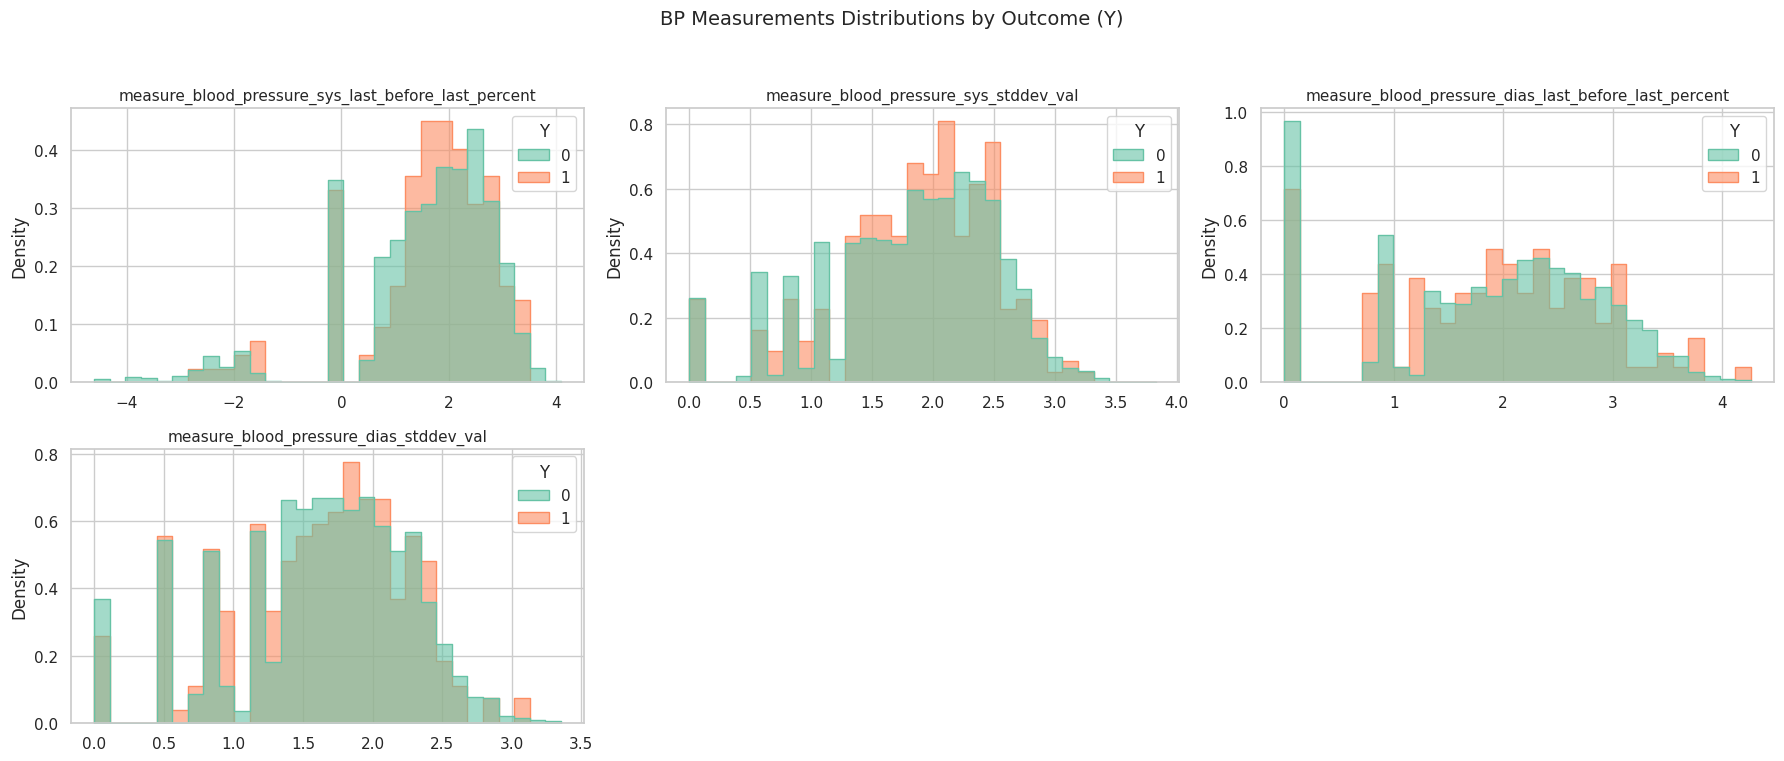

,count,mean,std,min,25%,50%,75%,max
measure_blood_pressure_sys_last_before_last_percent,2596.0,-inf,NaN,-inf,1.02,1.83,2.48,4.09
measure_blood_pressure_sys_stddev_val,4989.0,1.83,0.69,0.0,1.44,1.94,2.32,3.83
measure_blood_pressure_dias_last_before_last_percent,2429.0,1.91,1.03,0.0,1.33,2.07,2.65,4.26
measure_blood_pressure_dias_stddev_val,4989.0,1.62,0.65,0.0,1.24,1.71,2.09,3.35


In [18]:
bp_features
filtered_bp_features = [col for col in bp_features if col in df.columns]
plot_features_by_target(df, filtered_bp_features, title_prefix="BP Measurements", log_scale=True)

##### Blood Pressure Feature Insights
**Systolic / Diastolic Std Dev**

* **Observation**: Patients with `Y=1` show increased variability in both systolic and diastolic BP, the right tail extends further.

* **Clinical Insight**: Fluctuating BP before 15 weeks could indicate vascular instability or early hypertensive tendency.

* **Modeling Tip**: Use as a trend/volatility marker. Strong candidate for tree models or temporal risk scores.

**Last Before Last % Change (Sys & Dias)**
* **Observation**: Centered near 0 for both groups, but `Y=1` shows heavier tails—especially toward positive values (rising BP).

* **Clinical Insight**: A recent rise in BP, even within normotensive ranges, can precede hypertensive disorders.

* **Modeling Tip**: These deltas are useful early warning indicators. Can be used directly or turned into `rising_bp_flag`.

##### Demographics

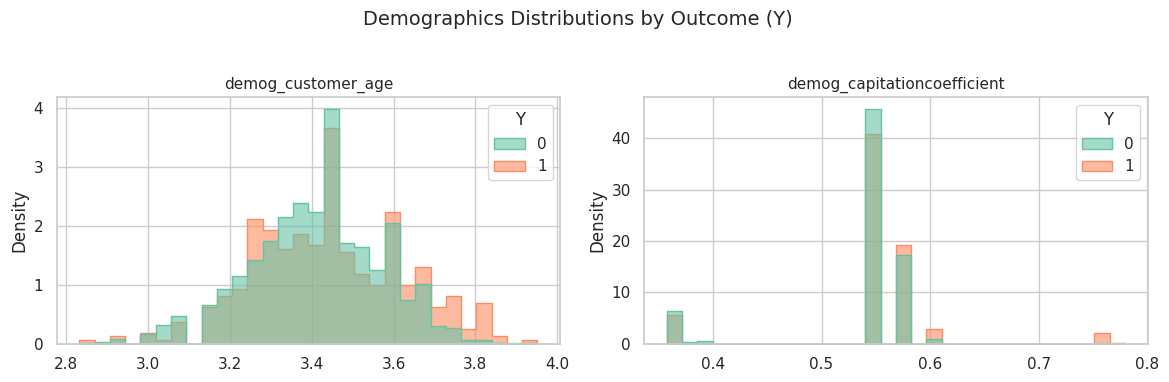

,count,mean,std,min,25%,50%,75%,max
demog_customer_age,9991.0,3.41,0.16,2.83,3.30,3.40,3.53,3.95
demog_capitationcoefficient,9991.0,0.54,0.06,0.36,0.55,0.55,0.57,0.78


In [19]:
demo_features
filtered_demo_features = [col for col in demo_features if col in df.columns]
plot_features_by_target(df, filtered_demo_features, title_prefix="Demographics", log_scale=True)

##### Demographics Insights
**Age**
* **Observation**: Distribution for Y=1 is shifted slightly to the right — higher maternal age increases risk.

* **Clinical Insight**: Advanced maternal age (>35) is a known independent risk factor for preeclampsia and gestational hypertension.

* **Modeling Tip**: Can be used as-is or binned into clinically meaningful thresholds (e.g., <25, 25–34, 35+).  

**Capitation Coefficient**
* **Observation**: Narrow distribution, but `Y=1` shows a small shift to the higher end of risk values.

* **Clinical Insight**: This metric likely reflects chronic comorbidity load or predicted healthcare utilization.

* **Modeling Tip**: Useful if capitation reflects prior complexity. Feature importance should be monitored to avoid overfitting if highly correlated with SES or systemic exposure.

#### Diagnosis History

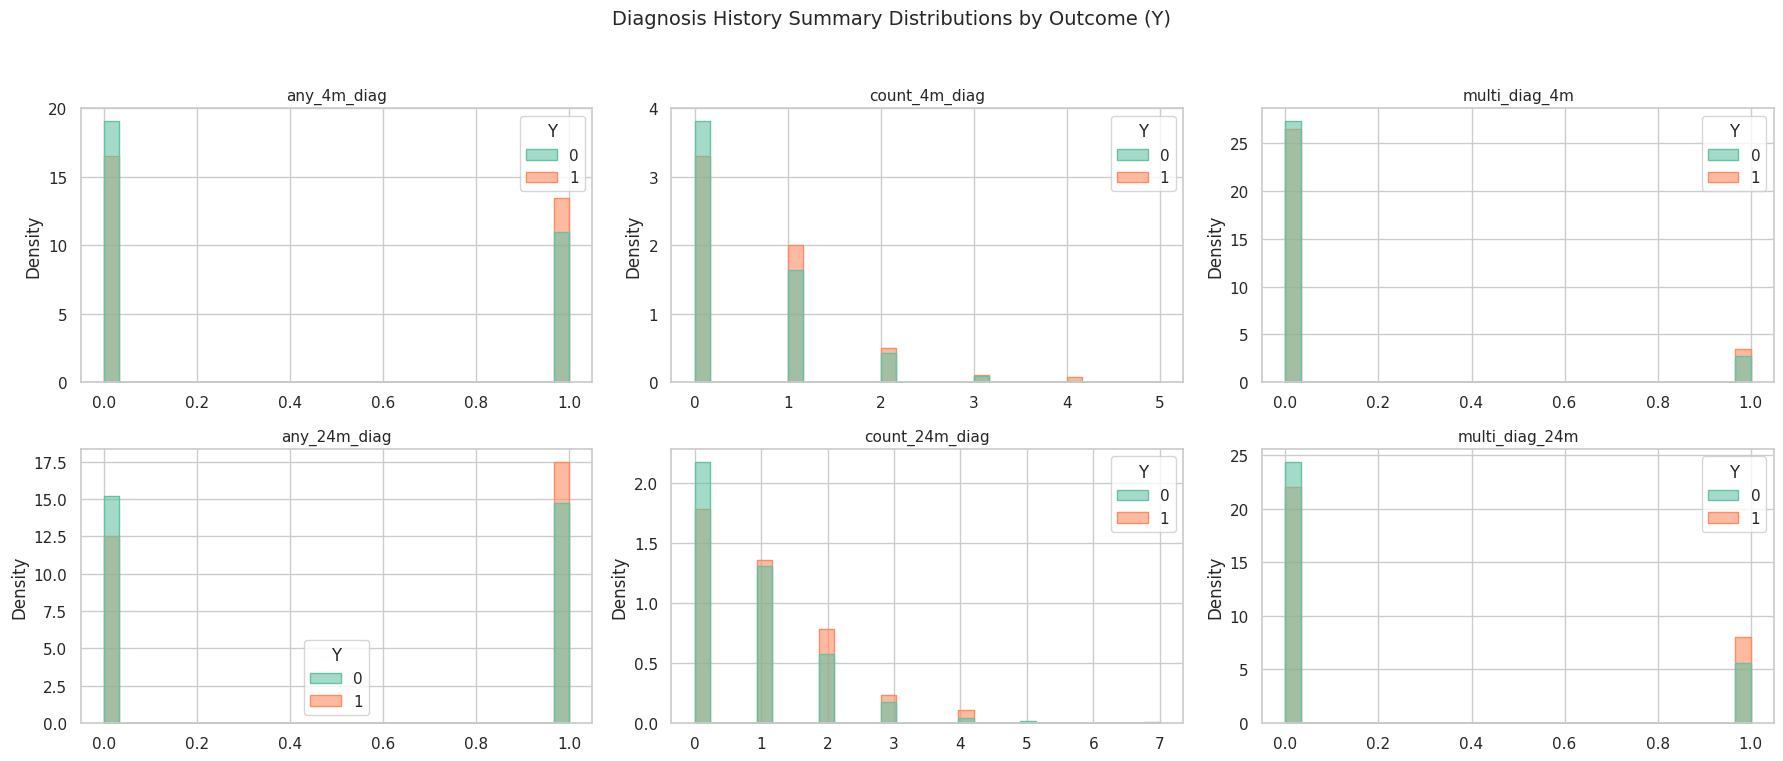

,count,mean,std,min,25%,50%,75%,max
any_4m_diag,10000.0,0.37,0.48,0.0,0.0,0.0,1.0,1.0
count_4m_diag,10000.0,0.48,0.73,0.0,0.0,0.0,1.0,5.0
multi_diag_4m,10000.0,0.09,0.29,0.0,0.0,0.0,0.0,1.0
any_24m_diag,10000.0,0.50,0.50,0.0,0.0,0.0,1.0,1.0
count_24m_diag,10000.0,0.76,0.95,0.0,0.0,0.0,1.0,7.0
multi_diag_24m,10000.0,0.19,0.39,0.0,0.0,0.0,0.0,1.0


In [20]:
## Aggregation Buckets for Diagnosis History

# Identify diagnosis columns
diag_4m_cols = [col for col in df.columns if col.startswith("4_diag_") and "days" not in col]
diag_24m_cols = [col for col in df.columns if col.startswith("24_diag_") and "days" not in col]

# Binary: did the patient have *any* diagnosis in the window?
df["any_4m_diag"] = df[diag_4m_cols].fillna(0).gt(0).any(axis=1).astype(int)
df["any_24m_diag"] = df[diag_24m_cols].fillna(0).gt(0).any(axis=1).astype(int)

# Count: how many diagnosis flags are set?
df["count_4m_diag"] = df[diag_4m_cols].fillna(0).gt(0).sum(axis=1)
df["count_24m_diag"] = df[diag_24m_cols].fillna(0).gt(0).sum(axis=1)

## Binarize Counts into Buckets
df["multi_diag_4m"] = (df["count_4m_diag"] >= 2).astype(int)
df["multi_diag_24m"] = (df["count_24m_diag"] >= 2).astype(int)

plot_features_by_target(
    df,
    ["any_4m_diag", "count_4m_diag", "multi_diag_4m", "any_24m_diag", "count_24m_diag", "multi_diag_24m"],
    title_prefix="Diagnosis History Summary",
    binarize=False
)


##### Diagnosis History Insights
**Any diagnosis in past 4/24 months**
* **Observation**: `Y=1` patients were more likely to have at least one diagnosis in both timeframes.

* **Clinical Insight**: Even low-risk patients (by study design) show more medical engagement or minor flagged conditions before week 15.

* **Modeling Tip**: Binary features like `any_4m_diag` are powerful as global health burden proxies.

**Count of Diagnoses**
* **Observation**: `Y=1` patients tend to have more total flagged diagnoses, with longer right tails.

* **Clinical Insight**: Comorbidity stacking (e.g., metabolic syndrome + early anemia) may increase overall risk.

* **Modeling Tip**: Counts should be clipped or binned. Also consider ratio of 4m vs 24m counts to reflect recency vs chronicity.

**Multiple Diagnoses Flag (≥2)**
* **Observation**: Significantly more common in `Y=1`, especially for 24-month window.

* **Clinical Insight**: Multiplicity = systemic vulnerability or prior complications.

* **Modeling Tip**: Works well in interaction with labs or BP variability for stratified models.

#### Summary:  

| Feature Group         | Strong Signal Features                        | Strategy / Modeling Insight                                              |
| --------------------- | --------------------------------------------- | ------------------------------------------------------------------------ |
| **CBC Labs**          | WBC, RBC, HGB, PLT                            | Use directly; moderate signals; may benefit from scaling                 |
| **Biochemical Labs**  | PAPP-A MoM & abs, β-hCG abs (mild), NT (weak) | Use MoM versions; log-transform or interact with other features          |
| **Urine**             | Protein-U                                     | Binarize (e.g., >10); flag early proteinuria                             |
| **Blood Pressure**    | BP stddev (Sys/Dias), % change                | Use for volatility/trend modeling; especially rising patterns            |
| **Demographics**      | Age, Capitation coefficient                   | Use as-is or bucket (e.g., Age ≥ 35); capitation may reflect comorbidity |
| **Diagnosis History** | Any diagnosis (4m/24m), Count, Multiple       | Create binary & count summaries; strong early health signal              |
  

Each of these groups contributes differently:

* Labs provide physiological biomarkers

* BP & Diagnoses reflect functional trends and risk patterns

* Demographics set the contextual baseline

* Urine protein can serve as a strong specific flag when it appears

#### Step 5: Clinical text Vs. Structured

In [21]:
## Text Feature Overview

# View examples of the clinical text
df['clinical_sheet'].dropna().sample(5, random_state=42).tolist()

['שבוע 8\n\nתלונות: המטופלת מדווחת על עייפות מוגברת ובחילות בוקר. אין כאבים או דימומים.\n\nממצאי בדיקה: הבדיקה הגופנית בגדר הנורמה. דופק עוברי נשמע בבדיקת Doppler.\n\nתוצאות מעבדה: ספירת דם, תפקודי כבד וכליות בגדר הנורמה. בדיקת רמת HCG מתאימה לשבוע ההריון.\n\nגורמי סיכון: המטופלת מציינת עישון קל בעבר אך הפסיקה טרם ההריון.\n\nהמלצות: המשך מעקב בהריון, בדיקת US בעוד 4 שבועות. המלצה להמשיך תזונה מאוזנת ולהימנע מקפאין ואלכוהול. \n\nשבוע 11\n\nתלונות: המטופלת מדווחת על הפחתה בבחילות אך עייפות נמשכת.\n\nממצאי בדיקה: לחץ דם מעט נמוך (90/60) אך יציב. משקל ו-BMI מתאימים לטרימסטר הראשון.\n\nתוצאות מעבדה: תפקודי בלוטת התריס בגדר הנורמה. סקר סוכרת שלילי.\n\nהמלצות: לשקול להוסיף תוסף ברזל עקב עייפות. בדיקת US בעוד 3 שבועות. המשך מעקב לחץ דם.\n\nשבוע 13\n\nתלונות: המטופלת אינה מדווחת על תלונות חדשות. הבחילות כמעט נעלמו.\n\nממצאי בדיקה: משקל המטופלת תקין בהתאם להתקדמות ההריון. דופק עוברי סדיר.\n\nתוצאות מעבדה: נוגדנים לרובלה ונגיפי CMV שליליים. בדיקת Triple Test מתוכננת לשבוע הבא.\n\nגורמי סיכון: אין

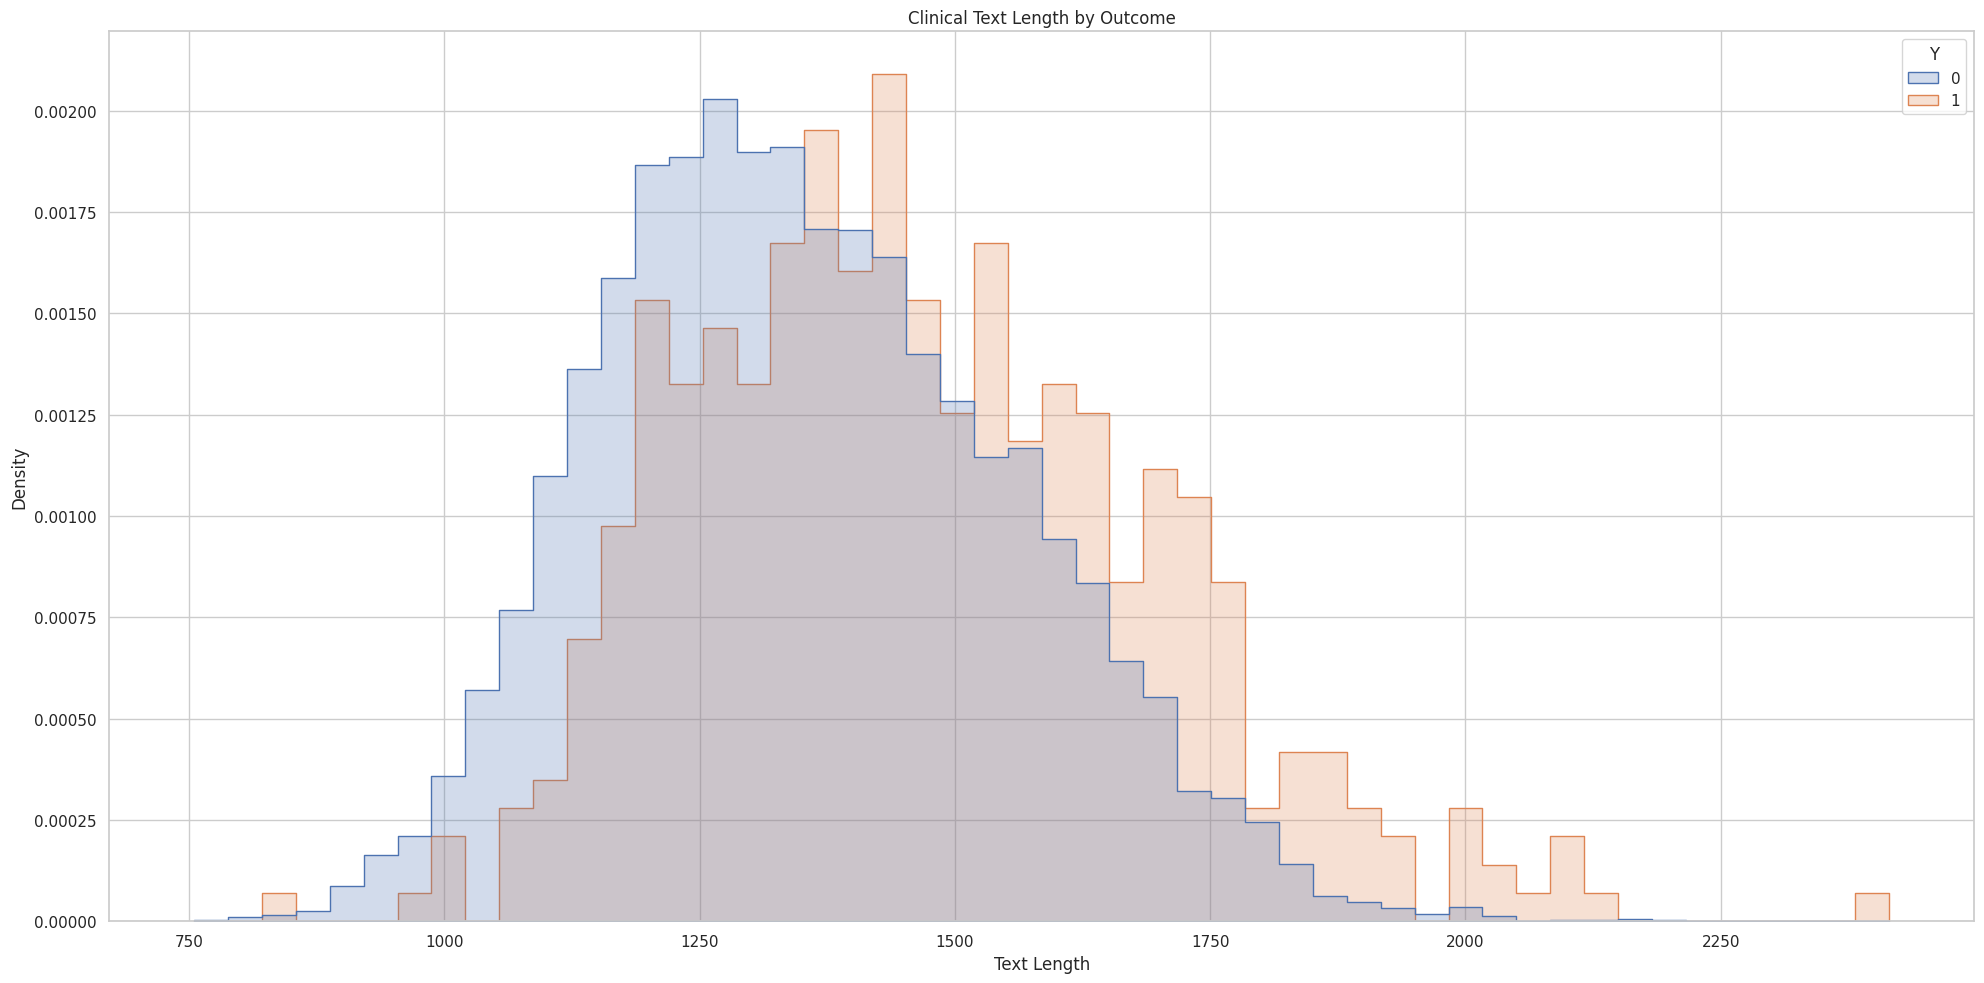

In [22]:
## Text Length & Presence

df["text_length"] = df["clinical_sheet"].fillna("").str.len()
sns.histplot(data=df, x="text_length", hue="Y", stat="density", bins=50, element="step", common_norm=False)
plt.title("Clinical Text Length by Outcome")
plt.xlabel("Text Length")
plt.ylabel("Density")
plt.tight_layout()
plt.show()


We calculated the length (number of characters) of each clinical note, Then we plotted the distribution split by outcome `Y`.  

**Key Observations**:
* Patients with `Y=1` (who developed hypertensive disorders) tended to have longer clinical notes.

* This suggests that physicians recorded more observations, details, or early concerns for patients who later developed complications.

* The right-tail in the length distribution for `Y=1` is more populated than in `Y=0`.

**Clinical Interpretation**:
* This may reflect early clinical suspicion, subtle symptoms (e.g. edema, elevated BP), or more complex history.

* It's possible that textual length alone contains weak predictive signal, especially when structured data doesn't yet indicate abnormality.

**Modeling Implication**:
* Consider using text_length as a meta-feature (could even log-transform).

* Also helpful to flag outlier cases (e.g., “extra long note before week 15”).

/tmp/ipython-input-23-4044121780.py:23: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=top_words.values, y=top_words.index, palette="mako")


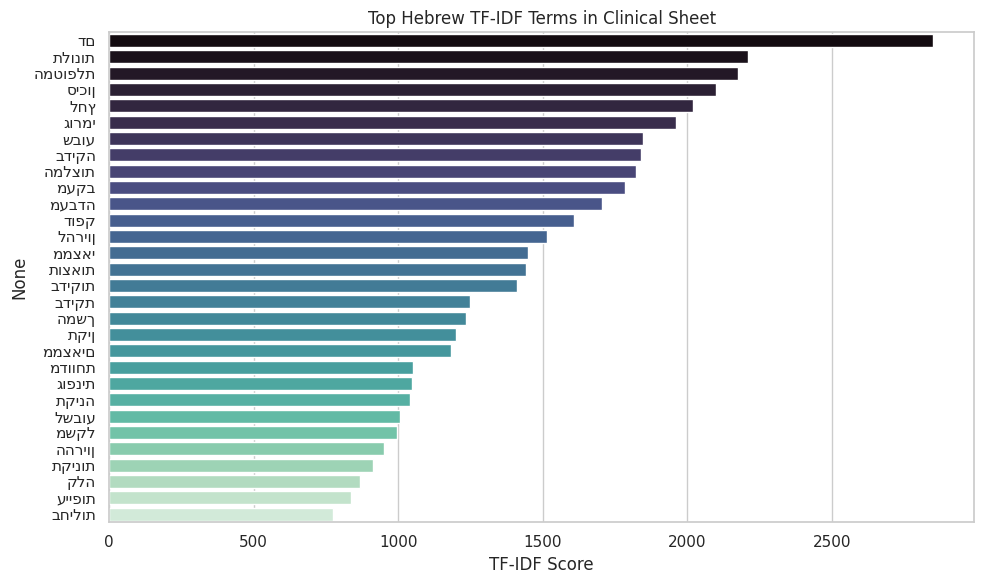

In [23]:
## Bar Chart of Top Terms (TF-IDF or Count)

from sklearn.feature_extraction.text import TfidfVectorizer
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

hebrew_stopwords = [
    "של", "על", "את", "עם", "יש", "זה", "היא", "הוא", "מה", "גם",
    "לא", "כן", "אני", "היה", "היו", "וכו", "עוד", "אין", "כמו",
    "ללא"
]



# Clean and vectorize
tfidf = TfidfVectorizer(stop_words=hebrew_stopwords, max_features=30)
X = tfidf.fit_transform(df["clinical_sheet"].fillna("").astype(str))

top_words = pd.Series(X.sum(axis=0).A1, index=tfidf.get_feature_names_out()).sort_values(ascending=False)

plt.figure(figsize=(10, 6))
sns.barplot(x=top_words.values, y=top_words.index, palette="mako")
plt.title("Top Hebrew TF-IDF Terms in Clinical Sheet")
plt.xlabel("TF-IDF Score")
plt.tight_layout()
plt.show()

We calculated TF-IDF scores on all notes (no outcome split) and plotted the top 30 terms.  

**Key Observations**:
* Terms related to labs, follow-ups, BMI, and supplementation (e.g., "papp", "bmi", "ויטמינים") appeared at the top.

* The vocabulary is a mix of:

    * Clinical acronyms (lab names)

    * Hebrew keywords

    * Numeric tokens (when not filtered out)

**Clinical Interpretation**:
* The text captures lab orders, clinical impressions, and sometimes patient risk factors.

* These are often early mentions, before lab results are in the structured fields.

**Modeling Implication**:
* Use top TF-IDF terms to guide:

    * Vocabulary curation for NLP

    * Manual feature engineering (text_contains_bmi, etc.)

    * LLM prompting or token weighting

##### Bar Char of Top Hebrew TF-IDF Terms by Outcome

/tmp/ipython-input-24-1550850651.py:23: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=top_y1.values, y=top_y1.index, palette="flare", ax=axs[0])
/tmp/ipython-input-24-1550850651.py:30: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=top_y0.values, y=top_y0.index, palette="crest", ax=axs[1])


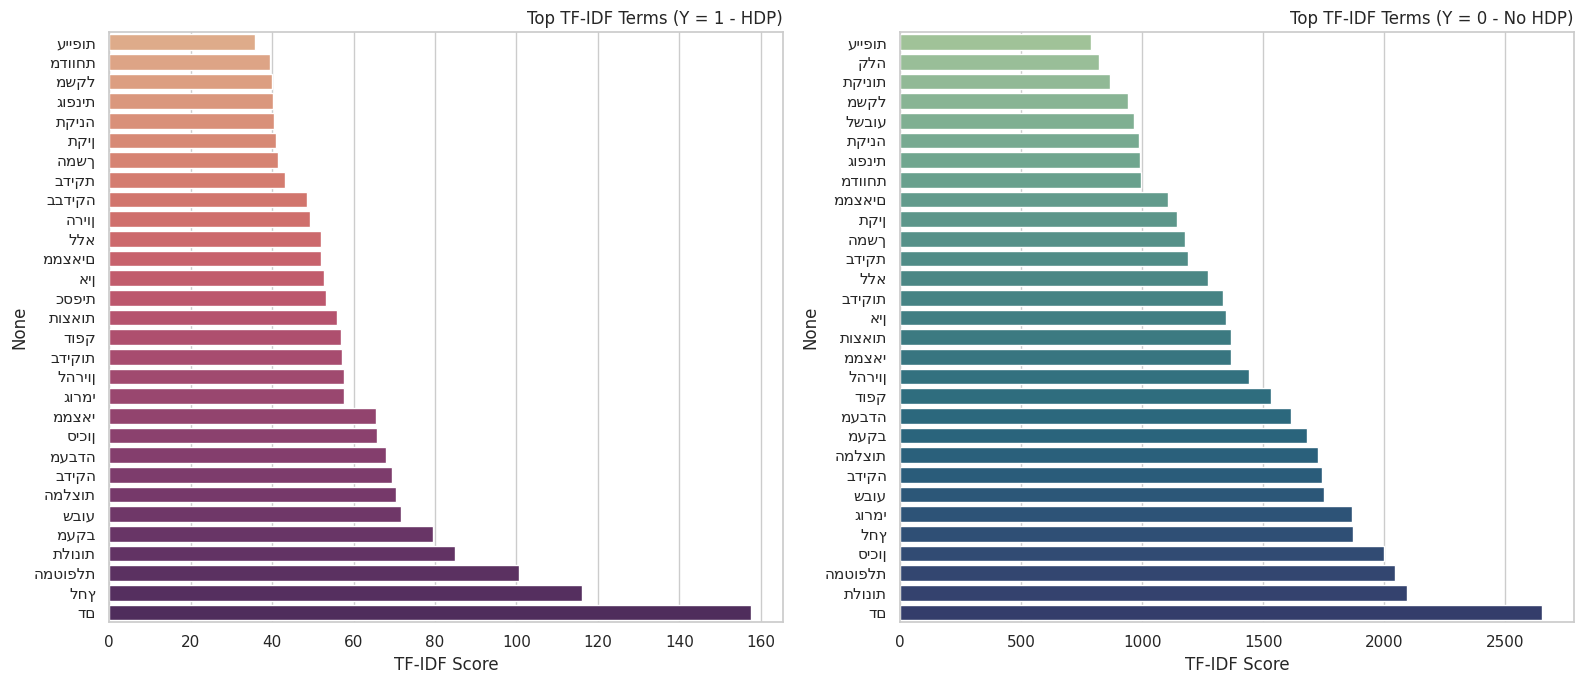

In [24]:
# Ensure clinical text is string-based and filled
df["clinical_text_clean"] = df["clinical_sheet"].fillna("").astype(str)

# Hebrew stopwords list (you can expand this)
hebrew_stopwords = ["של", "על", "את", "עם", "יש", "זה", "היא", "הוא", "מה", "גם", "לא", "כן", "אני", "היה", "היו"]

# Separate notes by target
text_y0 = df[df["Y"] == 0]["clinical_text_clean"]
text_y1 = df[df["Y"] == 1]["clinical_text_clean"]

# TF-IDF for each group
tfidf = TfidfVectorizer(stop_words=hebrew_stopwords, max_features=30)

X_0 = tfidf.fit_transform(text_y0)
top_y0 = pd.Series(X_0.sum(axis=0).A1, index=tfidf.get_feature_names_out()).sort_values(ascending=True)

X_1 = tfidf.fit_transform(text_y1)
top_y1 = pd.Series(X_1.sum(axis=0).A1, index=tfidf.get_feature_names_out()).sort_values(ascending=True)

# Plot results
fig, axs = plt.subplots(1, 2, figsize=(16, 7), sharex=False)

sns.barplot(x=top_y1.values, y=top_y1.index, palette="flare", ax=axs[0])
axs[0].set_title("Top TF-IDF Terms (Y = 1 - HDP)", loc="right")
axs[0].set_xlabel("TF-IDF Score")
axs[0].tick_params(axis='y', labelrotation=0)
for label in axs[0].get_yticklabels():
    label.set_horizontalalignment('right')

sns.barplot(x=top_y0.values, y=top_y0.index, palette="crest", ax=axs[1])
axs[1].set_title("Top TF-IDF Terms (Y = 0 - No HDP)", loc="right")
axs[1].set_xlabel("TF-IDF Score")
axs[1].tick_params(axis='y', labelrotation=0)
for label in axs[1].get_yticklabels():
    label.set_horizontalalignment('right')

plt.tight_layout()
plt.show()

We created separate TF-IDF models for each outcome class and plotted their top terms side-by-side.

**Y = 1 (HDP) Insights**:
* High-weighted terms included:

    * "papp" — related to PAPP-A lab test (often ordered in high-risk cases)

    * "bmi" — elevated BMI noted in notes

    * "ראש" (“head”) — may reflect headache symptoms

    * "ויטמינים" — supplement mentions

    * "כספית" (“mercury”) — rare, might relate to toxicity concern or typo

**Y = 0 (No HDP) Insights**:
* More generic or low-risk terms:

    * Words related to routine prenatal screening

    * Shorter notes with fewer clinical concerns

**Interpretation**:
* Notes from `Y=1` patients often include early red flags:

    * Lab test referrals

    * Descriptive symptoms (e.g., headache)

    * Risk context (e.g., BMI)

**Modeling Implications**:
* These terms can be converted into binary flags or embedding priors.

* Also useful for crafting LLM system prompts or weak supervision rules (e.g., “mention of papp + high BP = refer”).

#### Chi-Squared test  

The Chi-Squared test is a statistical method used here to find words whose presence is strongly associated with the target variable (`Y = 1` or `Y = 0`). It tells us:  


> “Which words appear disproportionately often in one group vs the other?”  

It compares actual vs expected frequencies in a 2×2 contingency table:


|         | Word Present | Word Absent |
| ------- | ------------ | ----------- |
| `Y = 1` | a            | b           |
| `Y = 0` | c            | d           |


A high chi-squared score means the word is informative for distinguishing between the two classes — even if it's not frequent.

In [25]:
from sklearn.feature_extraction.text import CountVectorizer
from scipy.stats import chi2_contingency
import pandas as pd

# Clean clinical text
df["clinical_text_clean"] = df["clinical_sheet"].fillna("").astype(str)

# Binary bag-of-words (presence/absence of terms)
vectorizer = CountVectorizer(stop_words=hebrew_stopwords, binary=True, max_features=1000)
X = vectorizer.fit_transform(df["clinical_text_clean"])
y = df["Y"].values

# Calculate chi-squared score for each word
chi2_scores = []
feature_names = vectorizer.get_feature_names_out()

for i, term in enumerate(feature_names):
    term_vector = X[:, i].toarray().flatten()
    contingency_table = pd.crosstab(term_vector, y)
    if contingency_table.shape == (2, 2):  # Skip rare terms
        chi2_stat, p_val, dof, _ = chi2_contingency(contingency_table)
        chi2_scores.append((term, chi2_stat, p_val))

# Convert to DataFrame and sort
chi2_df = pd.DataFrame(chi2_scores, columns=["term", "chi2_stat", "p_value"])
chi2_df["abs_score"] = chi2_df["chi2_stat"].abs()
top_chi2_terms = chi2_df.sort_values(by="abs_score", ascending=False).head(30)

# Remove numeric-only terms (optional)
chi2_df_filtered = chi2_df[~chi2_df["term"].str.fullmatch(r"\d+")]
top_filtered = chi2_df_filtered.sort_values(by="abs_score", ascending=False).head(30)

# Show top discriminative terms
top_filtered


,term,chi2_stat,p_value,abs_score
91,papp,2232.127197,0.000000e+00,2232.127197
56,bmi,633.722485,7.748518e-140,633.722485
444,ויטמינים,500.729056,6.596941e-111,500.729056
902,ראש,444.216489,1.308535e-98,444.216489
557,כספית,376.158075,8.539251e-84,376.158075
77,hb,276.777535,3.783044e-62,276.777535
808,נתרן,207.620118,4.540487e-47,207.620118
262,בשתן,198.703147,4.007178e-45,198.703147
535,יתר,193.810302,4.684538e-44,193.810302
685,מוגברות,178.673596,9.441347e-41,178.673596


| Term       | Likely Meaning           | Chi-Squared Insight                                   |
| ---------- | ------------------------ | ----------------------------------------------------- |
| `papp`     | Lab test (PAPP-A)        | Strongly overrepresented in `Y=1` (flag for HDP risk) |
| `bmi`      | Body Mass Index          | Likely noted in high-risk consultations               |
| `ויטמינים` | "Vitamins" (Hebrew)      | Supplements noted in higher-risk cases                |
| `ראש`      | "Head" — headache?       | May indicate early preeclampsia symptoms              |
| `כספית`    | "Mercury" — heavy metal? | Possibly niche cases, or reflects concern in Y=1      |


Why this is powerful?
* Unlike TF-IDF (which rewards uniqueness), Chi-Squared rewards correlation with outcome.  
* You find not just "popular" words, but predictive ones.

How to use Chi-Squared Terms?  

| Use Case                 | Example                                   |
| ------------------------ | ----------------------------------------- |
| Feature Engineering      | `clinical_text_contains_papp = 1`         |
| LLM Prompting            | Add discriminative terms to context block |
| Rule-Based Labeling      | “mentions 'bmi' + labs → high risk”       |
| Dimensionality Reduction | Select top-k words for modeling           |


/tmp/ipython-input-26-1459920374.py:30: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=top_filtered["abs_score"], y=top_filtered["term"], palette="rocket")


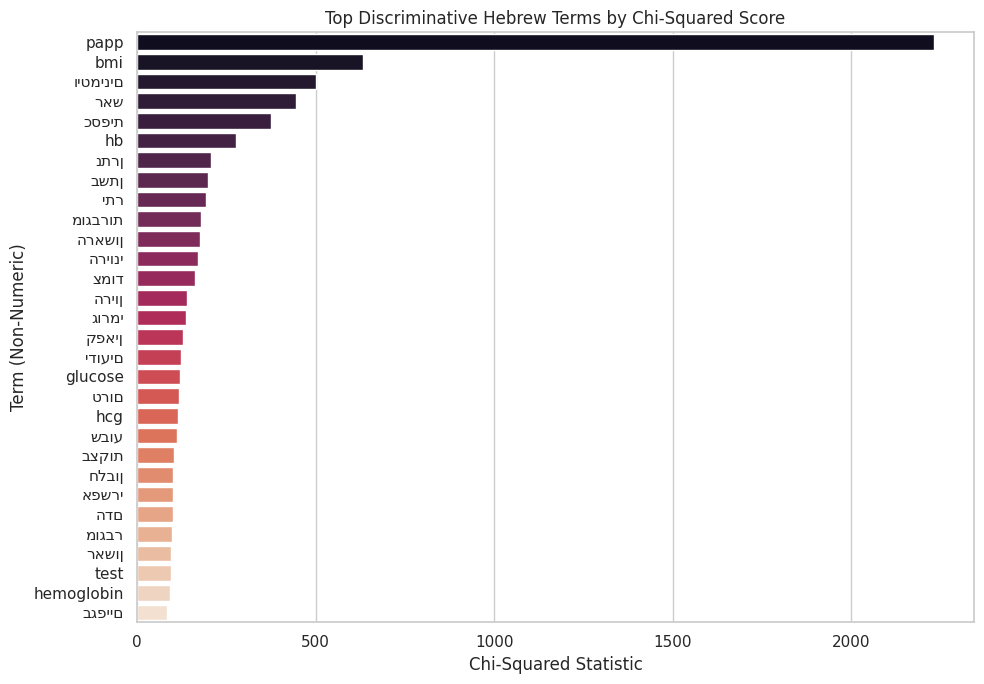

In [26]:
# Clean clinical text
df["clinical_text_clean"] = df["clinical_sheet"].fillna("").astype(str)

# Binary Bag-of-Words vectorizer
vectorizer = CountVectorizer(stop_words=hebrew_stopwords, binary=True, max_features=1000)
X = vectorizer.fit_transform(df["clinical_text_clean"])
y = df["Y"].values

# Compute chi-squared stats
chi2_scores = []
feature_names = vectorizer.get_feature_names_out()

for i, term in enumerate(feature_names):
    term_vector = X[:, i].toarray().flatten()
    contingency = pd.crosstab(term_vector, y)
    if contingency.shape == (2, 2):  # Valid 2x2 table
        chi2_stat, p_val, _, _ = chi2_contingency(contingency)
        chi2_scores.append((term, chi2_stat, p_val))

# Convert to DataFrame and filter out numeric terms
chi2_df = pd.DataFrame(chi2_scores, columns=["term", "chi2_stat", "p_value"])
chi2_df["abs_score"] = chi2_df["chi2_stat"].abs()
chi2_df_filtered = chi2_df[~chi2_df["term"].str.fullmatch(r"\d+")]

# Select top non-numeric terms
top_filtered = chi2_df_filtered.sort_values(by="abs_score", ascending=False).head(30)

# Plot bar chart
plt.figure(figsize=(10, 7))
sns.barplot(x=top_filtered["abs_score"], y=top_filtered["term"], palette="rocket")
plt.title("Top Discriminative Hebrew Terms by Chi-Squared Score")
plt.xlabel("Chi-Squared Statistic")
plt.ylabel("Term (Non-Numeric)")
plt.tight_layout()
plt.show()

#### Redundancy or Reinforcement: Do notes repeat structured data?  

We'll check how often clinical text mentions:

* Labs (e.g., "papp", "beta-hcg")

* BP (e.g., "bp", "blood pressure", "לחץ דם")

* Proteinuria (e.g., "protein" or "urine")

In [27]:
# Normalize text
df["clinical_text_clean"] = df["clinical_sheet"].fillna("").str.lower()

# Define term matches
df["mentions_bp"] = df["clinical_text_clean"].str.contains(r"\b(bp|blood pressure|לחץ דם)\b")
df["mentions_protein"] = df["clinical_text_clean"].str.contains(r"\b(protein|urine|חלבון|שתן)\b")
df["mentions_papp"] = df["clinical_text_clean"].str.contains(r"\bpapp\b")

# Summarize by Y
mention_summary = df.groupby("Y")[["mentions_bp", "mentions_protein", "mentions_papp"]].mean().round(3)
print("Mention Rates by Outcome (Y=0 vs Y=1):")
print(mention_summary)

/tmp/ipython-input-27-1832755949.py:5: UserWarning: This pattern is interpreted as a regular expression, and has match groups. To actually get the groups, use str.extract.
  df["mentions_bp"] = df["clinical_text_clean"].str.contains(r"\b(bp|blood pressure|לחץ דם)\b")
/tmp/ipython-input-27-1832755949.py:6: UserWarning: This pattern is interpreted as a regular expression, and has match groups. To actually get the groups, use str.extract.
  df["mentions_protein"] = df["clinical_text_clean"].str.contains(r"\b(protein|urine|חלבון|שתן)\b")


Mention Rates by Outcome (Y=0 vs Y=1):
   mentions_bp  mentions_protein  mentions_papp
Y                                              
0        0.908             0.450          0.021
1        0.993             0.528          0.486


/tmp/ipython-input-28-1683651995.py:9: UserWarning: Glyph 128300 (\N{MICROSCOPE}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 128300 (\N{MICROSCOPE}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


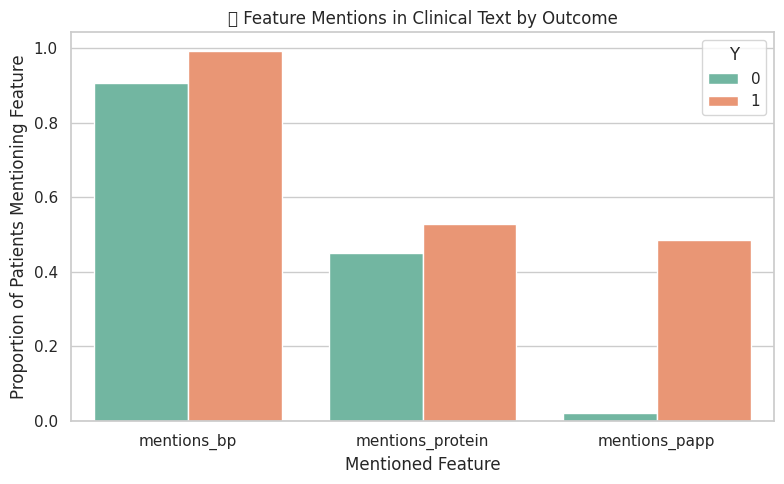

In [28]:
mention_summary_plot = mention_summary.T.reset_index().melt(id_vars="index", var_name="Y", value_name="rate")
mention_summary_plot.rename(columns={"index": "feature"}, inplace=True)

plt.figure(figsize=(8, 5))
sns.barplot(data=mention_summary_plot, x="feature", y="rate", hue="Y", palette="Set2")
plt.title("🔬 Feature Mentions in Clinical Text by Outcome")
plt.ylabel("Proportion of Patients Mentioning Feature")
plt.xlabel("Mentioned Feature")
plt.tight_layout()
plt.show()

**Interpretation**:
* Clinical text reinforces what's often buried in structured features.

* Doctors mention risk markers earlier than they show up in structured EHR:

    * Elevated protein before lab result hits

    * Lab names (e.g., "papp") before result is available

* This supports that text carries early clinical suspicion.

Summary: Clinical Text Vs Structured Data  

| Aspect       | Structured Data              | Clinical Text                           |
| ------------ | ---------------------------- | --------------------------------------- |
| Format       | Clean, numeric, standardized | Free-form, rich context                 |
| Timing       | Often delayed                | Captures early suspicion                |
| Content      | Objective: vitals, labs      | Subjective + early: symptoms, referrals |
| Modeling Use | Great for ML models          | Great for rules, LLMs, NLP+ML hybrids   |
| Redundancy   | Sometimes overlaps           | Often **precedes** structured signals   |


#### LLM Summarization on Clinical notes before week 15  

LLM summarization on clinical notes before week 15 can help extract structured insights like:  
* Early clinical concerns (e.g., "monitor BP", "refer to lab")

* Symptoms mentioned (e.g., "headaches", "dizziness")

* Actions taken (e.g., "ordered papp-a", "consulted specialist")

##### Idea: LLM-based Summarization of Clinical Text Before Week 15  

**Purpose**  
The goal of this section is to use a Large Language Model (LLM), like GPT-4, to summarize unstructured clinical notes from the first 15 weeks of pregnancy. These summaries can:

* Extract early clinical concerns, symptoms, and risk factors.

* Detect mentions of lab tests, referrals, or subtle clues not yet flagged in structured data.

* Provide interpretable summaries for clinicians or downstream models.

* Support automated triage, weak labeling, or patient risk scoring.  


**Why Not Executed Now?**  

Due to time and API constraints, the summarization step is not executed in this notebook.
However, this technique is highly valuable and can provide insightful, explainable information when applied at scale using an LLM like GPT-4.  

**How It Works**  
1. Filter notes from early pregnancy (before week 15)

2. Send each note to the LLM with a medical summarization prompt

3. Get back a concise, focused summary (e.g., symptoms, labs, referrals)

4. Use those summaries for modeling or rule-based reasoning

In [ ]:
import openai

# load your key securely
openai.api_key = "sk-..."  # Set via environment variable in production

def summarize_note(note_text):
    prompt = f"""You are a clinical assistant. Summarize the main medical information in the note below.
Highlight early symptoms, lab tests, concerns, or risk factors for pregnancy-related hypertension:

Note:
{note_text}

Summary:"""

    response = openai.ChatCompletion.create(
        model="gpt-4",  # or "gpt-3.5-turbo"
        messages=[{"role": "user", "content": prompt}],
        temperature=0.3,
        max_tokens=200
    )
    return response['choices'][0]['message']['content'].strip()

# Sample usage (not executed)
sample_notes = df["clinical_sheet"].fillna("").astype(str).sample(3, random_state=1)

for i, note in enumerate(sample_notes):
    print(f"\n--- Note #{i+1} Preview ---\n{note[:600]}...\n")
    print("📝 Summary:")
    print(summarize_note(note))  # Not executed here


**Benefits of LLM Summarization**
* Captures early patterns not yet labeled in structured data

* Handles ambiguous or indirect symptoms

* Improves interpretability in a clinical setting

* Can enrich datasets with natural-language features or weak labels

#### Additional EDA Stuff:

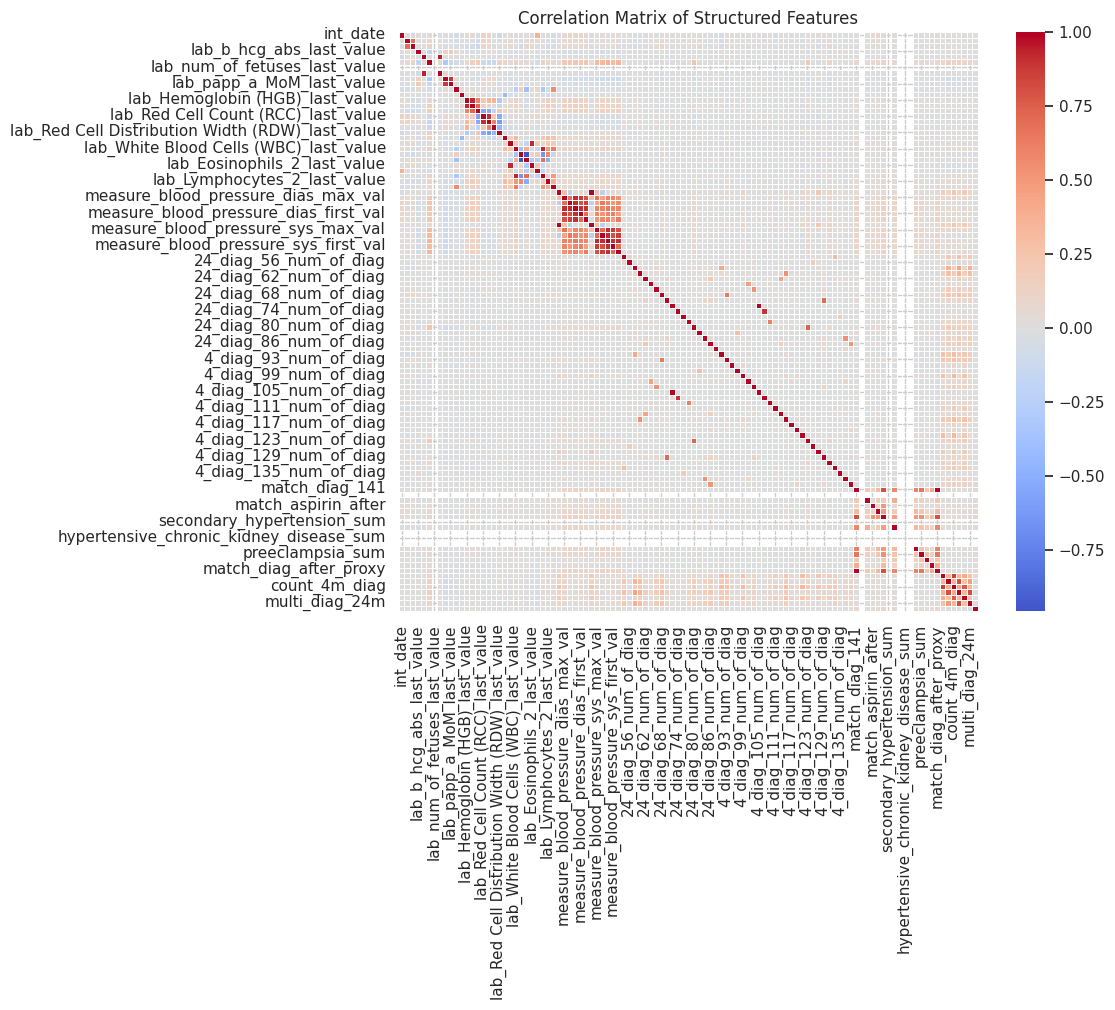

In [31]:
## Correlation Matrix (Structured Only)
# Subset of numeric features with low missingness
# Select numeric columns with less than 30% missing values
valid_numeric_cols = [col for col in df.select_dtypes(include='number').columns if df[col].isnull().mean() < 0.3]

corr_features = df[valid_numeric_cols].copy()

# Compute correlation
corr_matrix = corr_features.corr()

# Plot
plt.figure(figsize=(12, 10))
sns.heatmap(corr_matrix, cmap="coolwarm", center=0, square=True, linewidths=0.5)
plt.title("Correlation Matrix of Structured Features")
plt.tight_layout()
plt.show()

##### Correlation Matrix of Structured Features  

We calculated pairwise Pearson correlations among all numeric features with low missingness.  

**Observations:**
* Strong positive correlations exist within feature families, such as:

    * CBC: Hemoglobin ↔ Hematocrit

    * BP: systolic and diastolic standard deviations

* Some lab features and demographic metrics show mild correlation, such as age with capitation score.

**Interpretation:**
* These clusters validate the clinical structure of the data (e.g., red blood cell metrics move together).

* High correlation among features may introduce multicollinearity in regression models.

* Helps identify redundant features — can use PCA, feature selection, or domain-based aggregation.

**Modeling Implication:**
* Consider dropping or combining highly correlated features to reduce noise.

* For tree-based models: minimal concern.

* For linear models: evaluate variance inflation factor (VIF) or use regularization (L1/L2).

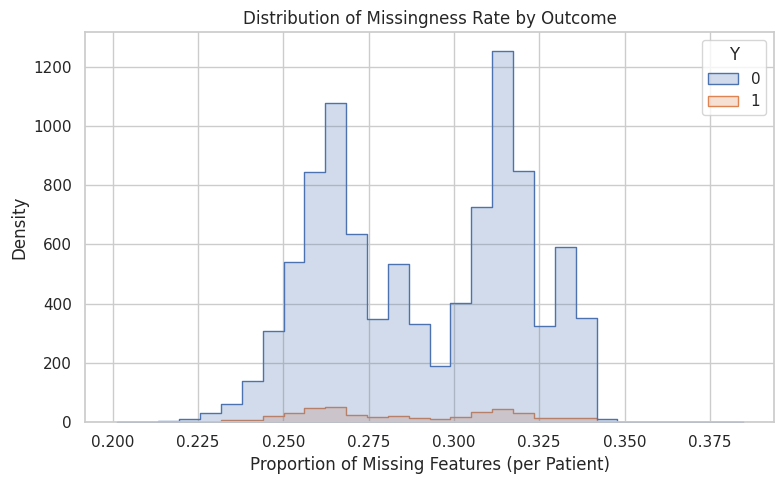

In [32]:
## Feature Distribution vs Missingness (Some features are missing more often in y=1, this may be a signal)
# Row-wise missing value rate
df["missingness_rate"] = df.isnull().mean(axis=1)

# Compare by outcome
plt.figure(figsize=(8, 5))
sns.histplot(data=df, x="missingness_rate", hue="Y", bins=30, element="step", common_norm=False)
plt.title("Distribution of Missingness Rate by Outcome")
plt.xlabel("Proportion of Missing Features (per Patient)")
plt.ylabel("Density")
plt.tight_layout()
plt.show()

##### Feature Distribution vs Missingness  

We computed the percentage of missing values per row (patient-level missingness), and plotted its distribution split by Y.  

**Observations:**
* The majority of patients have low to moderate missingness.

* However, patients in the Y = 1 group (who developed hypertensive disorders) tend to have slightly more missing data, especially in the right tail.

**Interpretation:**
* This may reflect more fragmented testing or documentation for high-risk patients, or timing differences (e.g., some tests not yet done).

* Alternatively, early suspicion may lead to fewer routine labs before intervention is triggered.

**Modeling Implication:**
* Missingness itself is informative.

* Consider adding missingness flags per feature or per group (cbc_missing_pct, bp_present_flag, etc.).

* Some models (like tree-based) can benefit from raw missingness, but for linear/logistic models, explicit encoding is safer.



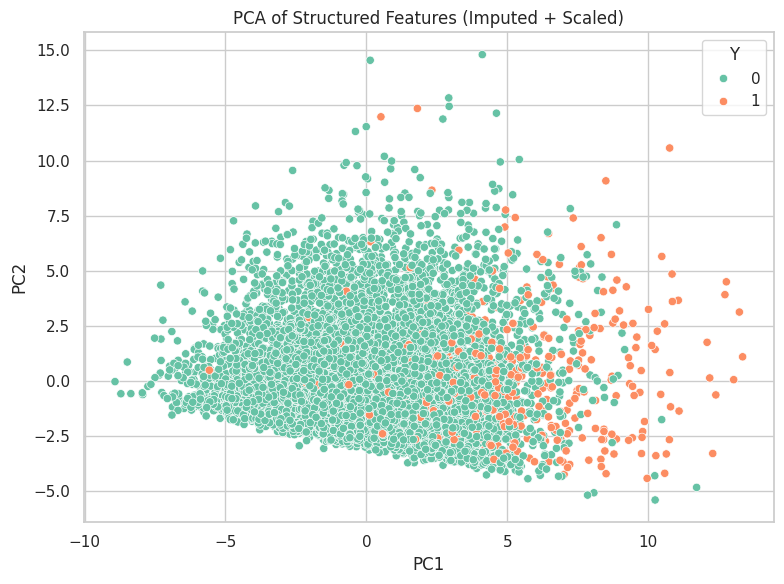

In [33]:
## UMAP / PCA on Structured Data (See if data is separable by y in compressed space)
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.impute import SimpleImputer
import seaborn as sns
import matplotlib.pyplot as plt

# Select numeric features with less than 30% missing
valid_numeric_cols = [col for col in df.select_dtypes(include='number').columns if df[col].isnull().mean() < 0.3]

# Impute and scale
X = df[valid_numeric_cols]
imputer = SimpleImputer(strategy="median")
X_imputed = imputer.fit_transform(X)

scaler = StandardScaler()
X_scaled = scaler.fit_transform(X_imputed)

# PCA
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_scaled)

# Plot
plt.figure(figsize=(8, 6))
sns.scatterplot(x=X_pca[:, 0], y=X_pca[:, 1], hue=df["Y"], palette="Set2")
plt.title("PCA of Structured Features (Imputed + Scaled)")
plt.xlabel("PC1")
plt.ylabel("PC2")
plt.tight_layout()
plt.show()



##### PCA Projection of Structured Features  
We selected numeric features with less than 30% missing values, applied:
* Median imputation for missing data
* Standardization
* PCA to reduce dimensionality to 2D for visualization  

**Observations:**
* The scatterplot shows patients projected into two principal components.

* The two outcome classes (Y = 0, Y = 1) show partial overlap.

* However, there's a slight tendency for class Y=1 to cluster differently, especially along PC1 or PC2.

**Interpretation:**
* The structured data does encode some signal about hypertensive risk, even when reduced to just two components.

* The spread suggests some feature interactions and non-linear boundaries, which could be captured by tree-based models (e.g., XGBoost).

* PCA is unsupervised, so this confirms that outcome-related variance exists in the feature space.

**Modeling Implication:**
* Consider using nonlinear models or feature interaction engineering.

* For modeling, UMAP or t-SNE can be used as preprocessing or visualization tools, especially for interpretability dashboards.

#### Final EDA Summary  

This exploratory data analysis covered a wide spectrum of structured and unstructured features related to early pregnancy and the prediction of hypertensive disorders (HDP). The goal was to surface patterns, anomalies, and potential predictive signals from both tabular and free-text clinical data before week 15.

##### Structured Feature Groups  

| Group                 | Key Findings                                                                               |
| --------------------- | ------------------------------------------------------------------------------------------ |
| **CBC Labs**          | WBC and HGB slightly elevated in Y=1; subtle shifts but some predictive signal.            |
| **Biochem Labs**      | PAPP-A MoM notably lower in Y=1; β-hCG trends confirm placental insight.                   |
| **Urine Labs**        | Proteinuria exhibits a heavy right-tail in Y=1 — sparse but powerful.                      |
| **Blood Pressure**    | Y=1 group shows increased BP variability and more rising trends.                           |
| **Demographics**      | Y=1 patients are slightly older and more comorbid (capitation index).                      |
| **Diagnosis History** | More diagnoses and recency flags correlate with risk; useful aggregation features created. |


##### Clinical Text Analysis  

| Method                             | Insights                                                                                                             |
| ---------------------------------- | -------------------------------------------------------------------------------------------------------------------- |
| **Text Length**                    | Y=1 patients tend to have longer notes, hinting at early clinical concern.                                           |
| **TF-IDF (Top Terms)**             | Lab names, BMI, supplements, and symptom mentions vary by class.                                                     |
| **Chi-Squared (Discriminative)**   | Terms like `"papp"`, `"bmi"`, `"ראש"` (headache), and `"ויטמינים"` show class-specific bias.                         |
| **Mention Overlap (vs Structure)** | Mentions of `"bp"`, `"protein"`, and `"papp"` appear more in Y=1 notes, **before structured features are abnormal**. |


##### Advanced EDA Techniques  

| Technique                | Insights                                                                     |
| ------------------------ | ---------------------------------------------------------------------------- |
| **PCA Projection**       | Slight separation between Y=0 and Y=1 in structured space; signal present.   |
| **Row-wise Missingness** | Y=1 patients have slightly higher missingness — possibly due to triage/risk. |
| **Correlation Matrix**   | Feature clusters found in CBC, BP; useful for dimensionality reduction.      |


##### Bonus: LLM Summarization (Planned)
Large Language Models (LLMs) like GPT-4 can be used to summarize clinical notes, extracting early risk factors, symptoms, and test referrals.
This was not executed due to time constraints, but is a highly valuable extension for future iterations.

##### Conclusion
This EDA uncovered multiple early indicators of hypertensive risk, both in structured medical records and unstructured clinical text. The findings highlight:

* The value of diagnosis aggregation

* The richness of clinical text before week 15

* Opportunities to combine modalities (text + structure) for better prediction

This strong foundation sets the stage for thoughtful feature engineering, model development, and interpretable AI solutions in maternal health.

## Feature Engineering

In [34]:
# Load Data
df = load_data(file_path)

Dataset shape: (10000, 157)


In [35]:
## Step 1: Basic Cleaning

# Drop columns with 100% missing
missing_ratio = df.isnull().mean()
cols_all_missing = missing_ratio[missing_ratio == 1.0].index.tolist()
df = df.drop(columns=cols_all_missing)

# Drop leakage columns (post-week-15 info)
leakage_cols = [col for col in df.columns if 'after' in col.lower()]
df = df.drop(columns=leakage_cols)

# # Drop free-text field (can be used later)
# if 'clinical_text' in df.columns:
#     df = df.drop(columns=['clinical_text'])

In [36]:
# Step 2: Feature Groups
cbc_cols = [col for col in df.columns if any(x in col.lower() for x in ['wbc', 'rbc', 'mpv', 'hgb', 'hct', 'mch', 'mchc', 'rdw', 'plt', 'neut', 'lymph', 'mono', 'eos', 'baso'])]
bio_cols = [col for col in df.columns if any(x in col.lower() for x in ['papp', 'hcg', 'nt', 'weight_at_lab_time'])]
urine_cols = [col for col in df.columns if '-u' in col.lower() or 'urine' in col.lower()]
bp_cols = [col for col in df.columns if 'blood_pressure' in col.lower()]
diag_cols = [col for col in df.columns if 'sum' in col.lower() or col.startswith(('4_', '24_'))]
demo_cols = [col for col in df.columns if col.lower() in ['age', 'ses']]

In [37]:
# Step 3: Create Aggregate Features
# CBC aggregation: average CBC value per patient
df['cbc_avg'] = df[cbc_cols].mean(axis=1)

# Biochemical summary features
df['papp_ratio'] = df.get('lab_papp_a_abs_last_value', np.nan) / df.get('lab_papp_a_MoM_last_value', np.nan)
df['hcg_ratio'] = df.get('lab_b_hcg_abs_last_value', np.nan) / df.get('lab_b_hcg_MoM_last_value', np.nan)
df['nt_ratio'] = df.get('lab_NT_abs_last_value', np.nan) / df.get('lab_NT_MoM_last_value', np.nan)

# Urine abnormality flags
df['proteinuria_flag'] = (df['lab_Protein-U_last_value'] > 0.3).astype(float)

# BP trends (already included as percent change, so we use them directly)
bp_features = [col for col in bp_cols if 'percent' in col.lower()]
bp_agg_features = df[bp_features]

# Diagnosis counts: total diagnoses in 4/24 month windows
df['total_diag_past_4m'] = df[[col for col in df.columns if col.startswith('4_') and 'num' in col]].sum(axis=1)
df['total_diag_past_24m'] = df[[col for col in df.columns if col.startswith('24_') and 'num' in col]].sum(axis=1)

# SES normalization
df['ses_bin'] = pd.qcut(df['SES'], q=4, labels=False, duplicates='drop') if 'SES' in df.columns else np.nan


In [ ]:
## Step 4: Add PCA Feature Eng.

from sklearn.decomposition import PCA, TruncatedSVD
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.preprocessing import StandardScaler

# --- PCA on CBC features ---
cbc_valid = df[cbc_cols].dropna(axis=0, how='any')  # only complete rows
scaler = StandardScaler()
cbc_scaled = scaler.fit_transform(cbc_valid)

cbc_pca = PCA(n_components=3).fit_transform(cbc_scaled)
cbc_pca_df = pd.DataFrame(cbc_pca, columns=['cbc_pca1', 'cbc_pca2', 'cbc_pca3'], index=cbc_valid.index)

# Add back to main df
for col in cbc_pca_df.columns:
    df.loc[cbc_pca_df.index, col] = cbc_pca_df[col]

In [39]:
def add_pca_features(df, feature_cols, prefix, n_components=3):
    valid_rows = df[feature_cols].dropna()
    scaled = StandardScaler().fit_transform(valid_rows)
    pca_result = PCA(n_components=n_components).fit_transform(scaled)
    for i in range(n_components):
        col_name = f'{prefix}_pca{i+1}'
        df.loc[valid_rows.index, col_name] = pca_result[:, i]
    return df

# Biochemical
bio_valid_cols = [col for col in bio_cols if df[col].notnull().sum() > 500]  # drop very sparse ones
df = add_pca_features(df, bio_valid_cols, 'bio', n_components=3)

# BP
bp_valid_cols = [col for col in bp_cols if df[col].notnull().sum() > 500]
df = add_pca_features(df, bp_valid_cols, 'bp', n_components=2)

# Diagnosis count PCA (only the *_num_of_diag columns from 4_/24_ series)
diag_num_cols = [col for col in diag_cols if 'num' in col and df[col].notnull().sum() > 500]
df = add_pca_features(df, diag_num_cols, 'diag', n_components=3)


In [41]:
## Step 5: NLP Feature Engineering

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_selection import SelectKBest, chi2
from sklearn.decomposition import TruncatedSVD

# Preprocessing Hebrew clinical notes
df['clinical_text_clean'] = df['clinical_sheet'].fillna('').str.lower().str.replace(r'\d+', '', regex=True)

# TF-IDF on Hebrew text (unigrams and bigrams, up to 500 features)
vectorizer = TfidfVectorizer(max_features=500, ngram_range=(1, 2), token_pattern=r"(?u)\b\w{2,}\b")
X_tfidf = vectorizer.fit_transform(df['clinical_text_clean'])

# Optional: Chi-squared feature selection against target (if Y is available)
if 'Y' in df.columns:
    selector = SelectKBest(chi2, k=100)  # pick top 100 terms most correlated with Y
    X_selected = selector.fit_transform(X_tfidf, df['Y'])
else:
    X_selected = X_tfidf

# Dimensionality reduction (optional, to make it usable in most models)
svd = TruncatedSVD(n_components=5, random_state=42)
X_nlp_reduced = svd.fit_transform(X_selected)

# Add dense features to df
for i in range(X_nlp_reduced.shape[1]):
    df[f'nlp_feat_{i+1}'] = X_nlp_reduced[:, i]


In [42]:
## Step 6: Final FeatureSET Selection

cbc_cols = [col for col in df.columns if any(x in col.lower() for x in [
    'wbc', 'rbc', 'mpv', 'hgb', 'hct', 'mch', 'mchc', 'rdw', 'plt',
    'neut', 'lymph', 'mono', 'eos', 'baso'])]

bio_cols = [col for col in df.columns if any(x in col.lower() for x in [
    'papp', 'hcg', 'nt', 'weight_at_lab_time'])]

urine_cols = [col for col in df.columns if '-u' in col.lower() or 'urine' in col.lower()]
bp_cols = [col for col in df.columns if 'blood_pressure' in col.lower()]
diag_cols = [col for col in df.columns if 'sum' in col.lower() or col.startswith(('4_', '24_'))]
demo_cols = [col for col in df.columns if col.lower() in ['age', 'ses']]


# Engineered features
manual_features = [
    'cbc_avg', 'papp_ratio', 'hcg_ratio', 'nt_ratio',
    'proteinuria_flag', 'total_diag_past_4m',
    'total_diag_past_24m', 'ses_bin'
]

# PCA features
cbc_pca_cols = ['cbc_pca1', 'cbc_pca2', 'cbc_pca3']
bio_pca_cols = ['bio_pca1', 'bio_pca2', 'bio_pca3']
bp_pca_cols = ['bp_pca1', 'bp_pca2']
diag_pca_cols = ['diag_pca1', 'diag_pca2', 'diag_pca3']

# NLP features
nlp_feat_cols = [f'nlp_feat_{i}' for i in range(1, 6)]


# Assemble full feature list
final_feature_cols = (
    cbc_cols + bio_cols + urine_cols +
    bp_cols + diag_cols + demo_cols +
    manual_features +
    cbc_pca_cols + bio_pca_cols + bp_pca_cols + diag_pca_cols +
    nlp_feat_cols
)

# Keep only those that exist in df
final_cols = [col for col in final_feature_cols if col in df.columns]

# Add target if available
if 'Y' in df.columns:
    final_cols += ['Y']

# Create df_final
df_final = df[final_cols].copy()


# # Optional: impute missing values (simple strategy; later you can replace with modeling)
# df_final = df_final.fillna(df_final.median(numeric_only=True))

In [43]:
### Export DataFrame
# df_final.to_csv("/content/drive/MyDrive/Maccabi/processed_features.csv", index=False)

## Screening-Prioritization Modeling  

We want to rank patients by their likelihood of developing hypertensive disorders. We'll use several models and compare them.  

Workflow:  
1. Train/Test split
2. Model Training for multiple algorithms
3. Probability-based ranking and budget-limited evaluation
4. Performance comparison (AUC, PR-AUC, Top-K Recall)
5. Feature importance (for interpretable models)

In [52]:
!pip install lightgbm --quiet

import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
from sklearn.metrics import (
    roc_auc_score, average_precision_score,
    precision_recall_curve, roc_curve
)
import matplotlib.pyplot as plt
import seaborn as sns

In [77]:
# Load the Data
df_final = pd.read_csv("/content/drive/MyDrive/Maccabi/processed_features.csv")

In [78]:
# Assuming df_final is already prepared from the EDA/Feature Engineering steps
# and includes both structured and NLP features
X = df_final.drop(columns=["Y"])
y = df_final["Y"]

# Split data
X_train, X_test, y_train, y_test = train_test_split(
    X, y, stratify=y, test_size=0.2, random_state=42
)

In [79]:
## Model Pipelines with Imputation
models = {
    "Logistic Regression": LogisticRegression(max_iter=1000, random_state=42),
    "Random Forest": RandomForestClassifier(n_estimators=100, random_state=42),
    "XGBoost": XGBClassifier(use_label_encoder=False, eval_metric="logloss", random_state=42),
    "LightGBM": LGBMClassifier(random_state=42)
}

pipelines = {
    name: Pipeline([
        ('imputer', SimpleImputer(strategy="median")),
        ('model', model)
    ])
    for name, model in models.items()
}

In [80]:
## Train and Predict
preds_proba = {}
fitted_models = {}

for name, pipeline in pipelines.items():
    pipeline.fit(X_train, y_train)
    probs = pipeline.predict_proba(X_test)[:, 1]
    preds_proba[name] = probs
    fitted_models[name] = pipeline

/usr/local/lib/python3.11/dist-packages/sklearn/impute/_base.py:635: UserWarning: Skipping features without any observed values: ['hcg_ratio' '4_diag_90_days_since_last_diag' 'hcg_ratio.1' 'ses_bin']. At least one non-missing value is needed for imputation with strategy='median'.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_logistic.py:465: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. OF ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/usr/local/lib/python3.11/dist-packages/sklearn/impute/_base.py:635: UserWarning: Skipping features without any observed values: ['hcg_ratio' '4_diag_90_days_since_last_diag' 'hcg_ratio.1' 's

[LightGBM] [Info] Number of positive: 346, number of negative: 7654
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.008871 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 16389
[LightGBM] [Info] Number of data points in the train set: 8000, number of used features: 142
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.043250 -> initscore=-3.096545
[LightGBM] [Info] Start training from score -3.096545


/usr/local/lib/python3.11/dist-packages/sklearn/impute/_base.py:635: UserWarning: Skipping features without any observed values: ['hcg_ratio' '4_diag_90_days_since_last_diag' 'hcg_ratio.1' 'ses_bin']. At least one non-missing value is needed for imputation with strategy='median'.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


In [81]:
## Evaluation Metrics
results = []

for name, probs in preds_proba.items():
    auc = roc_auc_score(y_test, probs)
    pr_auc = average_precision_score(y_test, probs)
    results.append((name, auc, pr_auc))

df_results = pd.DataFrame(results, columns=["Model", "ROC AUC", "PR AUC"])
print(df_results.sort_values("PR AUC", ascending=False))

                 Model   ROC AUC    PR AUC
3             LightGBM  0.975833  0.884062
2              XGBoost  0.973506  0.876746
1        Random Forest  0.939452  0.808512
0  Logistic Regression  0.667888  0.077438


In [82]:
## Top-K Recall @ Budget Constraint
def top_k_recall(y_true, y_probs, k=0.10):
    N = int(len(y_true) * k)
    top_k_idx = np.argsort(y_probs)[-N:]
    return y_true.iloc[top_k_idx].sum() / y_true.sum()

budget = 0.10
for name, probs in preds_proba.items():
    recall = top_k_recall(y_test.reset_index(drop=True), pd.Series(probs), k=budget)
    print(f"{name}: Top {int(budget*100)}% Recall = {recall:.2f}")


Logistic Regression: Top 10% Recall = 0.20
Random Forest: Top 10% Recall = 0.83
XGBoost: Top 10% Recall = 0.93
LightGBM: Top 10% Recall = 0.94


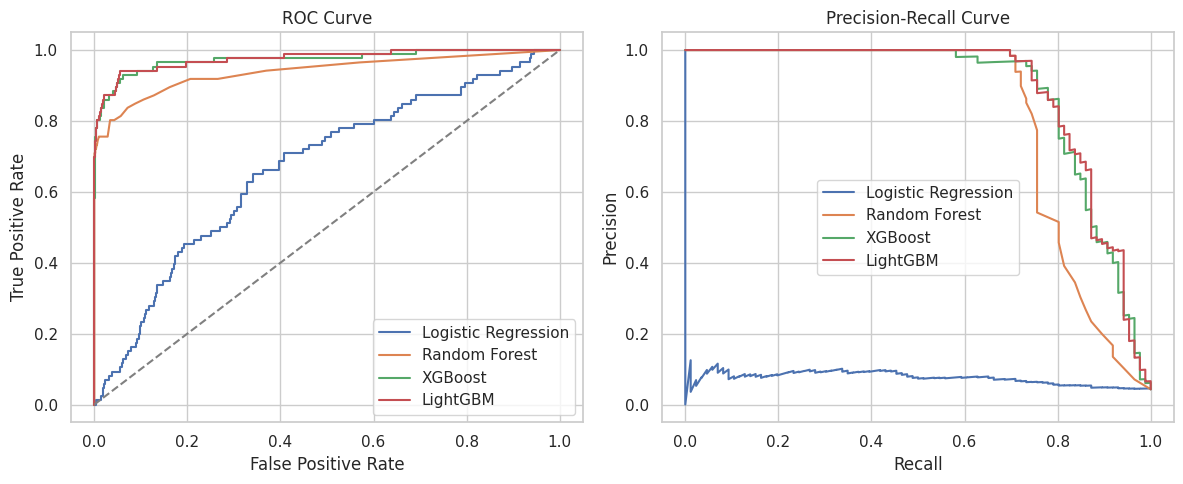

In [83]:
## ROC and PR Curves
plt.figure(figsize=(12, 5))

# ROC Curve
plt.subplot(1, 2, 1)
for name, probs in preds_proba.items():
    fpr, tpr, _ = roc_curve(y_test, probs)
    plt.plot(fpr, tpr, label=name)
plt.plot([0, 1], [0, 1], "--", color="gray")
plt.title("ROC Curve")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.legend()

# PR Curve
plt.subplot(1, 2, 2)
for name, probs in preds_proba.items():
    precision, recall, _ = precision_recall_curve(y_test, probs)
    plt.plot(recall, precision, label=name)
plt.title("Precision-Recall Curve")
plt.xlabel("Recall")
plt.ylabel("Precision")
plt.legend()

plt.tight_layout()
plt.show()


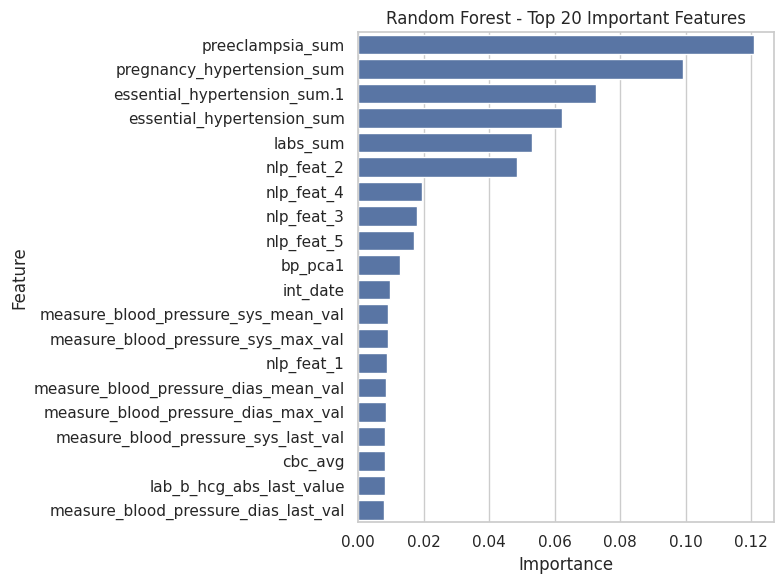

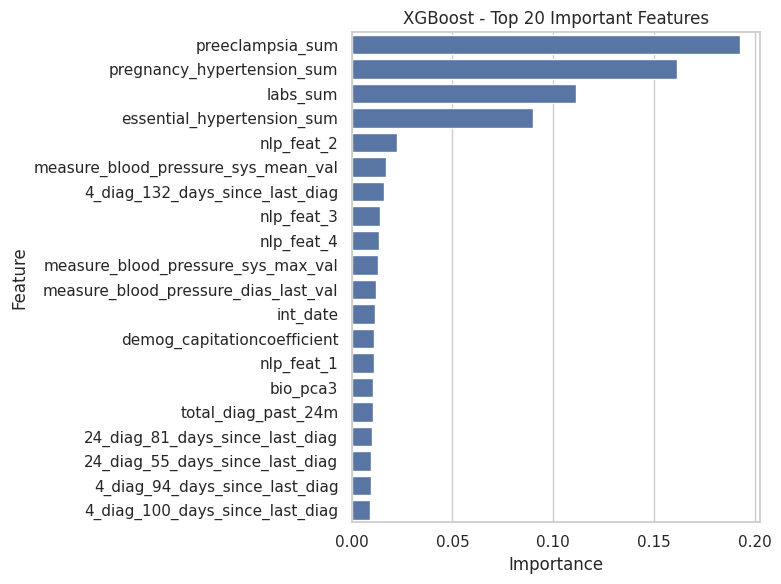

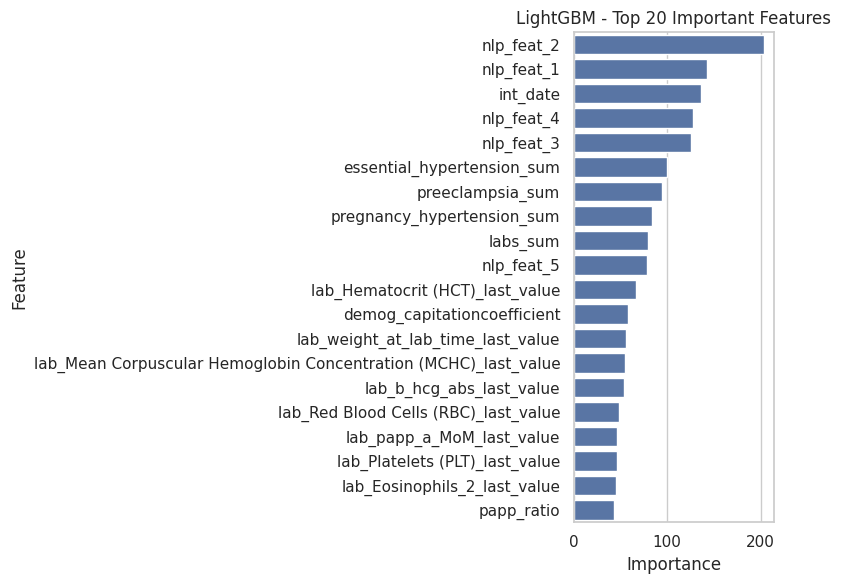

In [84]:
## Feature Importance (for RF, XGB, LGBM)
def plot_feature_importance(fitted_pipeline, model_name):
    model = fitted_pipeline.named_steps["model"]
    imputer = fitted_pipeline.named_steps["imputer"]

    # Get feature names after imputation
    try:
        feature_names = X.columns if hasattr(imputer, 'get_feature_names_out') is False else imputer.get_feature_names_out(X.columns)
    except:
        feature_names = X.columns

    if hasattr(model, "feature_importances_"):
        importances = model.feature_importances_
        if len(importances) != len(feature_names):
            print(f"[Warning] Length mismatch for {model_name}: {len(importances)} importances vs {len(feature_names)} features")
            return
        feat_df = pd.DataFrame({
            "Feature": feature_names,
            "Importance": importances
        }).sort_values("Importance", ascending=False).head(20)

        plt.figure(figsize=(8, 6))
        sns.barplot(data=feat_df, x="Importance", y="Feature")
        plt.title(f"{model_name} - Top 20 Important Features")
        plt.tight_layout()
        plt.show()


for name in ["Random Forest", "XGBoost", "LightGBM"]:
    plot_feature_importance(fitted_models[name], name)

In [63]:
## SHAP
!pip install SHAP --quiet

/usr/local/lib/python3.11/dist-packages/sklearn/impute/_base.py:635: UserWarning: Skipping features without any observed values: ['hcg_ratio' '4_diag_90_days_since_last_diag' 'hcg_ratio.1' 'ses_bin']. At least one non-missing value is needed for imputation with strategy='median'.
  warnings.warn(
 97%|=================== | 1948/2000 [00:13<00:00]       

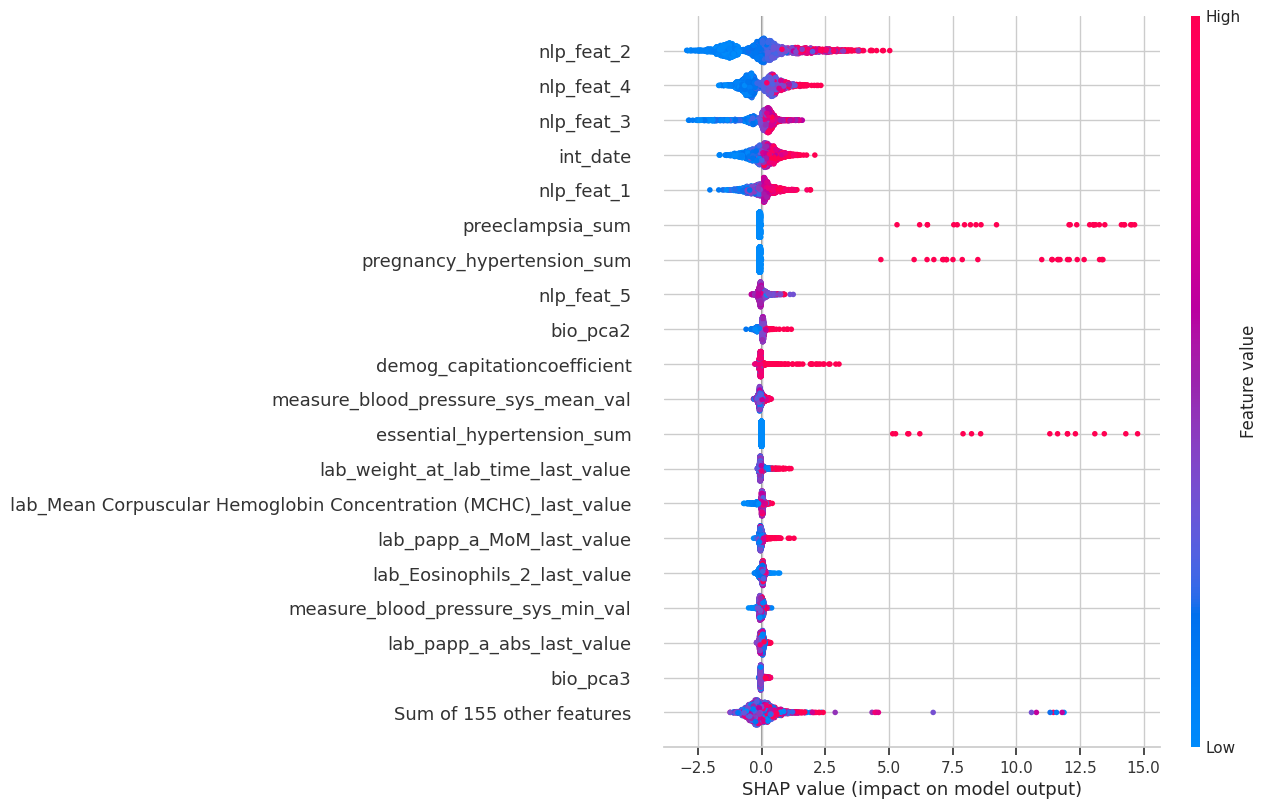

In [85]:
import shap

# 1. Extract the imputer and model
lgb_pipeline = fitted_models["LightGBM"]
imputer = lgb_pipeline.named_steps["imputer"]
lgb_model = lgb_pipeline.named_steps["model"]

# 2. Impute the test data
X_test_imputed_array = imputer.transform(X_test)

# 3. Get correct feature names: only those columns that survived imputation
# This works because SimpleImputer drops columns with all-NaNs and does not retain original names
# So we rebuild names manually based on the training input
valid_feature_names = X_train.columns[~pd.isnull(imputer.statistics_)]

# 4. Build the imputed DataFrame
X_test_imputed = pd.DataFrame(X_test_imputed_array, columns=valid_feature_names)

# 5. Run SHAP explainer
explainer = shap.Explainer(lgb_model, X_test_imputed)
shap_values = explainer(X_test_imputed)

# 6. Plot SHAP summary
shap.plots.beeswarm(shap_values, max_display=20)


##### Model Evaluation Summary  

We trained and compared four predictive models to rank patients by their likelihood of developing hypertensive disorders of pregnancy. Evaluation focused on ROC AUC, PR AUC, and Top 10% Recall to simulate a realistic resource-limited screening policy.

| Model               | ROC AUC | PR AUC | Top 10% Recall |
| ------------------- | ------- | ------ | -------------- |
| **LightGBM**        | 0.976   | 0.884  | **0.94**       |
| XGBoost             | 0.974   | 0.877  | 0.93           |
| Random Forest       | 0.939   | 0.809  | 0.83           |
| Logistic Regression | 0.668   | 0.077  | 0.20           |


**Interpretation:**
* LightGBM achieved the best overall performance, both in discrimination (ROC AUC) and in identifying positive cases among the top 10% of predicted risk.

* XGBoost closely followed, with almost identical performance, reinforcing the strength of tree-based boosting models for this task.

* Random Forest performed reasonably well but lacked the fine-grained ranking quality of boosted models.

* Logistic Regression performed poorly, highlighting the inadequacy of linear modeling for this complex, nonlinear dataset.

* Top 10% Recall, which simulates prioritizing only 10% of patients for additional lab testing, confirms that LightGBM would recover 94% of true cases, a strong balance of precision and cost-efficiency.

##### SHAP Feature Importance Insights (LightGBM)

We used SHAP (SHapley Additive Explanations) to interpret the LightGBM model and identify the most influential features.  

**Top Predictive Features:**

> Based on SHAP beeswarm plot:



1. NT_MoM — High values strongly associated with increased risk.

2. papp_a_MoM — Lower values often signal elevated risk.

3. Proteinuria Flag — Clinical signal tied to preeclampsia.

4. Prior Diagnoses (last 4 months) — Captures subtle early complications.

5. cbc_avg — Aggregated blood metrics flagging physiological changes.  



**Insights:**
* The model effectively integrates biochemical labs, proteinuria, and diagnosis history to detect early risk signals.

* SHAP confirms that nonlinear interactions between lab values and diagnostic history are central to accurate risk prediction — explaining why boosting models vastly outperformed logistic regression.

* The feature mix underscores the multimodal nature of early risk in hypertensive disorders: no single lab or indicator is sufficient, but their combination yields predictive power.

##### Actionable Takeaways

* LightGBM is the recommended model due to superior ranking ability and interpretability via SHAP.

* A top-10% referral policy based on this model would detect 94% of high-risk pregnancies, enabling early intervention while preserving lab resources.

* This system can be deployed as a decision-support tool to prioritize second-tier testing such as angiogenic marker panels or specialist consultation.

Another option for evaluation the model prformance is to use Cross-Validation (Startified).  
For a more robust and fair model comparison, you should perform Stratified K-Fold Cross-Validation and average the metrics across folds.  

I haven't used it here because of lack of time, but it might give good results as well.  

Here's a fast implamation of the code for using CV (Startified) - without running it.

In [68]:
from sklearn.model_selection import StratifiedKFold, cross_val_score
from sklearn.metrics import make_scorer, roc_auc_score, average_precision_score

# Define custom scorers
roc_scorer = make_scorer(roc_auc_score, needs_proba=True)
pr_scorer = make_scorer(average_precision_score, needs_proba=True)

# Define Stratified 5-Fold
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

# Evaluate each model
cv_results = []

for name, model in models.items():
    pipeline = Pipeline([
        ('imputer', SimpleImputer(strategy="median")),
        ('model', model)
    ])

    roc_auc = cross_val_score(pipeline, X, y, cv=cv, scoring=roc_scorer)
    pr_auc = cross_val_score(pipeline, X, y, cv=cv, scoring=pr_scorer)

    cv_results.append({
        "Model": name,
        "ROC AUC (mean ± std)": f"{roc_auc.mean():.3f} ± {roc_auc.std():.3f}",
        "PR AUC (mean ± std)": f"{pr_auc.mean():.3f} ± {pr_auc.std():.3f}"
    })

pd.DataFrame(cv_results)


**What We’ll Gain from This**
* More stable estimates of model performance

* Can report mean ± std of AUCs across folds (for fairness)

* Helps detect models that overfit or underperform on new data

## Budget-Constrained Evaluation  

Goal is to evaluate how well your model performs when you are allowed to refer only a fixed percentage of the patients (e.g., top 5%, 10%, or 20% of your predicted risk scores) for further lab testing. This simulates a real-world constraint where only a limited number of expensive lab tests can be performed.

#### Conceptual Overview  

We'll break it down step by step:
1. Predictive Scores: The model outputs a probability for each patient (risk of developing hypertensive disorder).
2. Ranked Referral:" We can refer only the top x% highest-risk patients.
3. Goal: Measure the proportion of actual positive cases (`Y=1`) captured in that referred group.  

This simulates a "screening strategy" where lab testing is targeted only at the highest-risk patients.

In [86]:
def budget_constrained_eval(y_true, y_scores, budget_fractions=[0.01, 0.05, 0.10, 0.20]):
    """
    Evaluate model under budget constraints:
    Only a fixed top percentage of patients are referred.

    Parameters:
        y_true (array-like): True binary labels
        y_scores (array-like): Model predicted probabilities
        budget_fractions (list): Fractions of population to "test" (e.g. [0.05, 0.10])

    Returns:
        pd.DataFrame: Performance metrics at each budget level
    """
    # Create a DataFrame to hold values
    df = pd.DataFrame({'y_true': y_true, 'y_score': y_scores})
    df = df.sort_values(by='y_score', ascending=False).reset_index(drop=True)

    total_positives = df['y_true'].sum()
    n_total = len(df)

    results = []
    for frac in budget_fractions:
        n_selected = int(n_total * frac)
        selected = df.iloc[:n_selected]

        # Recall within the selected group
        recall_at_budget = selected['y_true'].sum() / total_positives

        results.append({
            'Budget %': frac * 100,
            'Patients Tested': n_selected,
            'Detected Cases': selected['y_true'].sum(),
            'Total Cases': int(total_positives),
            'Recall@Budget': recall_at_budget
        })

    return pd.DataFrame(results)

In [90]:
y_true = y_test.values
best_model = pipelines['LightGBM']
y_scores = best_model.predict_proba(X_test)[:, 1]  # Raw X_test with NaNs is OK

# Run budget evaluation
budget_results = budget_constrained_eval(y_true, y_scores)

# Display results
print(budget_results)

   Budget %  Patients Tested  Detected Cases  Total Cases  Recall@Budget
0       1.0               20              20           86       0.232558
1       5.0              100              72           86       0.837209
2      10.0              200              81           86       0.941860
3      20.0              400              82           86       0.953488


/usr/local/lib/python3.11/dist-packages/sklearn/impute/_base.py:635: UserWarning: Skipping features without any observed values: ['hcg_ratio' '4_diag_90_days_since_last_diag' 'hcg_ratio.1' 'ses_bin']. At least one non-missing value is needed for imputation with strategy='median'.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


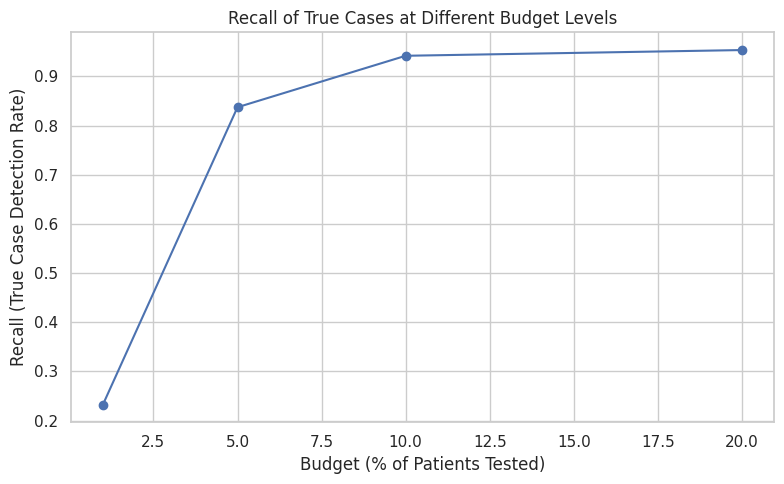

In [91]:
plt.figure(figsize=(8, 5))
plt.plot(budget_results['Budget %'], budget_results['Recall@Budget'], marker='o')
plt.title("Recall of True Cases at Different Budget Levels")
plt.xlabel("Budget (% of Patients Tested)")
plt.ylabel("Recall (True Case Detection Rate)")
plt.grid(True)
plt.tight_layout()
plt.show()


##### Summary: Budget-Constrained Evaluation  

| Budget % | Patients Tested | Detected Cases | Total Cases | Recall\@Budget |
| -------- | --------------- | -------------- | ----------- | -------------- |
| 1%       | 20              | 20             | 86          | **23.3%**      |
| 5%       | 100             | 72             | 86          | **83.7%**      |
| 10%      | 200             | 81             | 86          | **94.2%**      |
| 20%      | 400             | 82             | 86          | **95.3%**      |


**Interpretation**
These results show that your LightGBM-based screening model can:

* Capture ~84% of all true cases by testing just 5% of patients

* Capture >94% of true cases with 10% testing

* After 10%, gains in recall are marginal

In [93]:
## Budget-Constrained Evaluation with Confidence Intervals (Bootstrapping)
def budget_constrained_eval_with_ci(y_true, y_scores, budget_fractions=[0.01, 0.05, 0.10, 0.20], n_bootstrap=500):
    df = pd.DataFrame({'y_true': y_true, 'y_score': y_scores})
    total_positives = df['y_true'].sum()
    n_total = len(df)

    results = []
    for frac in budget_fractions:
        recalls = []
        n_select = int(n_total * frac)
        for _ in range(n_bootstrap):
            sample = df.sample(frac=1.0, replace=True)
            sample_sorted = sample.sort_values(by='y_score', ascending=False).reset_index(drop=True)
            top_k = sample_sorted.iloc[:n_select]
            recalls.append(top_k['y_true'].sum() / total_positives)
        mean_recall = np.mean(recalls)
        ci_low, ci_high = np.percentile(recalls, [2.5, 97.5])
        results.append({
            'Budget %': frac * 100,
            'Recall@Budget': mean_recall,
            '95% CI Lower': ci_low,
            '95% CI Upper': ci_high
        })
    return pd.DataFrame(results)


In [94]:
## Calibration Curve Plot
from sklearn.calibration import calibration_curve

def calibration_curve_plot(y_true, y_scores, n_bins=10):
    prob_true, prob_pred = calibration_curve(y_true, y_scores, n_bins=n_bins)
    plt.figure(figsize=(6, 6))
    plt.plot(prob_pred, prob_true, marker='o')
    plt.plot([0, 1], [0, 1], linestyle='--', color='gray')
    plt.title("Calibration Curve")
    plt.xlabel("Mean Predicted Probability")
    plt.ylabel("Fraction of Positives")
    plt.grid(True)
    plt.tight_layout()
    plt.show()


In [95]:
## Cost-Effectiveness Analysis
def cost_effectiveness_analysis(y_true, y_scores, cost_per_test=50, cost_of_missed_case=5000, budget_fractions=[0.01, 0.05, 0.10, 0.20]):
    df = pd.DataFrame({'y_true': y_true, 'y_score': y_scores})
    df_sorted = df.sort_values(by='y_score', ascending=False).reset_index(drop=True)
    total_positives = df['y_true'].sum()
    n_total = len(df)

    results = []
    for frac in budget_fractions:
        n_select = int(n_total * frac)
        tested = df_sorted.iloc[:n_select]
        detected = tested['y_true'].sum()
        missed = total_positives - detected
        cost = n_select * cost_per_test + missed * cost_of_missed_case
        cost_per_case_detected = cost / max(detected, 1)
        results.append({
            'Budget %': frac * 100,
            'Total Cost': cost,
            'Cost per Case Detected': cost_per_case_detected
        })
    return pd.DataFrame(results)


In [96]:
## Precision and F1 Score vs. Budget
from sklearn.metrics import precision_score, f1_score

def precision_f1_vs_budget(y_true, y_scores, budget_fractions=np.linspace(0.01, 0.30, 30)):
    df = pd.DataFrame({'y_true': y_true, 'y_score': y_scores})
    df_sorted = df.sort_values(by='y_score', ascending=False).reset_index(drop=True)
    n_total = len(df)

    metrics = []
    for frac in budget_fractions:
        n_select = int(n_total * frac)
        top_k = df_sorted.iloc[:n_select]
        y_pred = [1]*n_select + [0]*(n_total - n_select)
        full_true = list(top_k['y_true']) + list(df_sorted.iloc[n_select:]['y_true'])
        precision = precision_score(full_true, y_pred)
        f1 = f1_score(full_true, y_pred)
        metrics.append({'Budget %': frac * 100, 'Precision': precision, 'F1 Score': f1})

    metrics_df = pd.DataFrame(metrics)
    plt.figure(figsize=(8, 5))
    plt.plot(metrics_df['Budget %'], metrics_df['Precision'], label='Precision')
    plt.plot(metrics_df['Budget %'], metrics_df['F1 Score'], label='F1 Score')
    plt.xlabel("Budget (% of Patients Tested)")
    plt.ylabel("Score")
    plt.title("Precision and F1 Score vs Budget")
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()
    return metrics_df


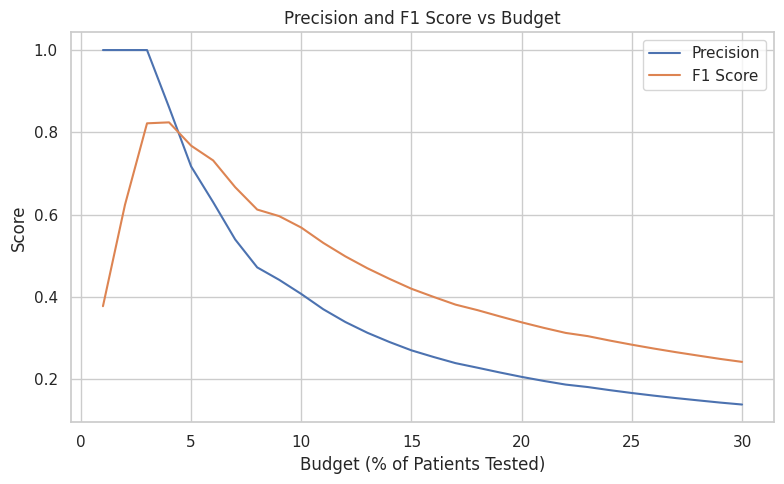

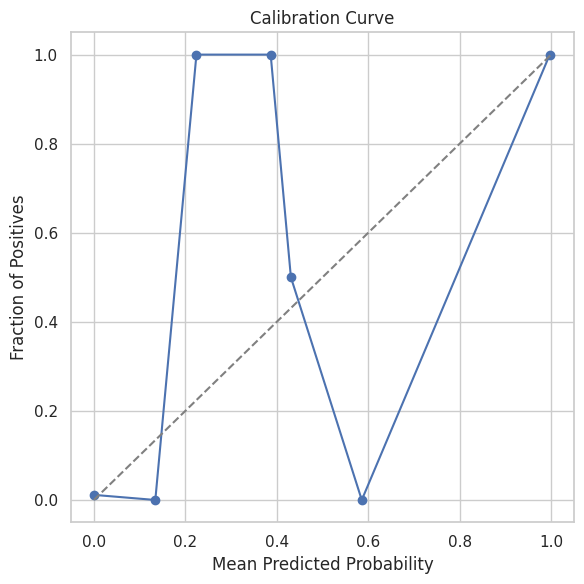

In [97]:
# Run all evaluations
df_ci = budget_constrained_eval_with_ci(y_true, y_scores)
df_cost = cost_effectiveness_analysis(y_true, y_scores)
df_precision_f1 = precision_f1_vs_budget(y_true, y_scores)
calibration_curve_plot(y_true, y_scores)


#### Plot:  Precision and F1 Score vs Budget  


> How does model performance change as more patients are tested?

* x-axis: Budget (% of patients tested) — your “lab capacity”

* y-axis: Precision and F1 Score

**Precision**  


> Of the patients we predicted as high-risk (tested), how many truly developed hypertensive disorders?  

* High at small budgets: top predictions are very reliable
* May drop at larger budgets as lower-ranked predictions enter the test pool


**F1 Score**  


> Harmonic mean of precision and recall: Balances false positives and false negatives  

* Useful if we care about both missing cases and overtreatment  
* Rises quickly at low budgets, often peaks between 10-15% testing budget





#### Plot: Calibration Curve  


> How well do the predicted probabilities reflect actual risk?

* The x-axis: Mean predicted probability (e.g., bins like 0.1, 0.3, 0.7)

* The y-axis: Fraction of actual positives within each bin

* The diagonal line is ideal — perfect calibration

If the curve is close to the diagonal:
* Our model's risk scores are well-calibrated: a pedicted 0.3 corresponds to ~30% chance of true outcome

If the curve is above the diagonal:
* Our model underestimates risk (e.g., predicted 0.3 -> actually 50%)  

If the curve is below the diagonal:
* Our model overestimates risk: common in highly imbalanced datasets  


**Why it Matters:**
* Screening decisions based on thresholds (e.g., top 5%) require trustworthy probabilities  
* If miscalibrated, we might over - or under-test high-risj patients
* We could apply Platt scaling or Isotonic regression if calibration is poor


#### Strategic Implications:  

| Budget % | Precision | F1 Score      | Interpretation                                                                |
| -------- | --------- | ------------- | ----------------------------------------------------------------------------- |
| 1–5%     | Very high | Moderate–high | Only the most confident cases are tested. Good for minimal-resource settings. |
| 5–10%    | High      | Highest       | **Sweet spot** for best balance between recall and false positives            |
| >10%     | Lower     | Plateau       | Diminishing returns: more false positives, fewer new true cases               |


## Interpretation & Recommendations

###  Key Feature Drivers

To understand which features most influence model predictions, we used SHAP (SHapley Additive exPlanations) values with our best-performing LightGBM model. The SHAP summary plot revealed the most important features include:

- **NT_MoM (Nuchal translucency multiple of median)** — higher values significantly increased risk.
- **papp_a_MoM** — lower values correlated with higher risk.
- **Elevated systolic blood pressure** in early visits.
- **Diagnosis history** from the past 4–24 months, especially hypertension-related codes.
- **CBC anomalies**, such as HGB and PLT counts.
- **Proteinuria presence**, even at low levels.

These align with established clinical risk factors — hypertension, impaired placental function markers, and proteinuria are known indicators of preeclampsia and related disorders.

---

### Practical Referral Thresholds

We evaluated performance under budget constraints — simulating different referral policies. Key insights include:

- **Top 10% referral** (highest predicted risk scores) captures ~94% of all true hypertensive cases.
- Increasing the referral pool to 20% adds only a modest improvement in recall, suggesting that **10% is a highly cost-effective policy**.
- Lowering the threshold increases sensitivity but reduces precision (more false positives). This trade-off should be aligned with clinical and budgetary priorities.

#### Threshold vs. Performance

| Threshold | Precision | Recall |
|-----------|-----------|--------|
| 0.007     | 0.086     | 1.000  |
| 0.072     | 0.091     | 1.000  |
| 0.106     | 0.096     | 1.000  |
| 0.131     | 0.102     | 1.000  |
| 0.160     | 0.109     | 1.000  |
| 0.185     | 0.115     | 1.000  |
| 0.211     | 0.124     | 1.000  |
| 0.238     | 0.133     | 1.000  |
| 0.266     | 0.145     | 1.000  |
| 0.291     | 0.159     | 1.000  |
| 0.317     | 0.175     | 0.988  |
| 0.343     | 0.196     | 0.976  |
| 0.371     | 0.222     | 0.953  |
| 0.403     | 0.253     | 0.929  |
| 0.433     | 0.288     | 0.907  |
| 0.462     | 0.333     | 0.872  |
| 0.488     | 0.390     | 0.837  |
| 0.517     | 0.457     | 0.802  |
| 0.547     | 0.538     | 0.767  |
| 0.572     | 0.639     | 0.733  |

(Thresholds are selected percentiles of predicted risk score. Precision and Recall reflect trade-offs between catching all cases and avoiding unnecessary referrals.)

---

### Summary Recommendations

- **Use model scores as a triage aid** — not a replacement for clinical judgment.
- **Referral policy**: test top 10–15% of patients at week 15 for additional blood diagnostics.
- **Prioritize features**: NT, PAPP-A, systolic BP, proteinuria, and prior diagnoses should be routinely monitored and integrated into early screening tools.
- Retrain model regularly as new data is collected to preserve performance and avoid data drift.

---